In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Pandas
import pandas as pd

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

# #astropy coorindates/units
# from astropy.coordinates import SkyCoord
# import astropy.constants as const
# import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Functions used in this code
import age_functions as afunc

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [2]:
###################
### Import Data ###
###################

gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parseclinage.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

# supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
#                     names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
#                            'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
#                            'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
#                            'RelativeAge'],sep='\s+')

In [3]:
########################
### Xmatch NGC Names ###
########################

supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

supp2 = supp2[s2_ind]
supp2['harris_dist'] = np.array([12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,5.9,
                                 9.9,2.3,11.6,3.2,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
supp2['harris_feh'] = np.array([-1.18,-1.14,-1.59,-1.80,-2.23,-2.10,-2.27,-1.53,-1.50,-1.98,-1.29,-1.16,-1.76,
                                -1.02,-1.53,-1.37,-1.56,-0.45,-0.55,-2.02,-0.46,-1.70,-1.49,-1.10,-1.54,-1.94,
                                -0.78,-2.37,-1.65])

In [121]:
supp2['Cluster']

len(np.squeeze(s2_ind))

29

In [4]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [5]:
# harris distance
# APOGEE [Fe/H]
# Age supp2
# Ak = Ejk_med/1.5

In [6]:
lits_isos = []
exts = []
clus_feh_apo = []
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    clus_feh_med = np.median(gcs['FE_H'][clus])
    clus_feh_apo.append(clus_feh_med)
    age = np.log10(supp2['Age'][i]*10**9)
    
    exts.append(gcs['Ejk_med'][clus])
    
    lits_isos.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(clus_feh_med,parsec['MH'])))])
    

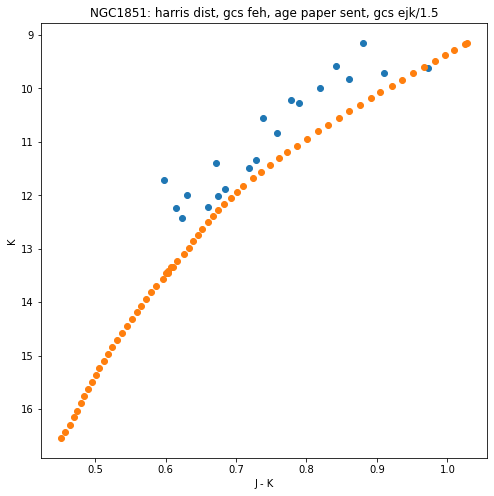

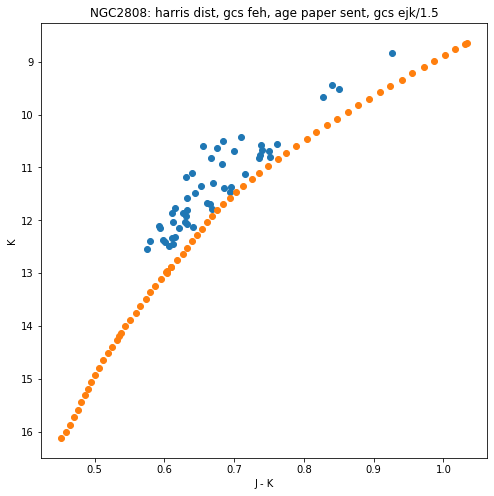

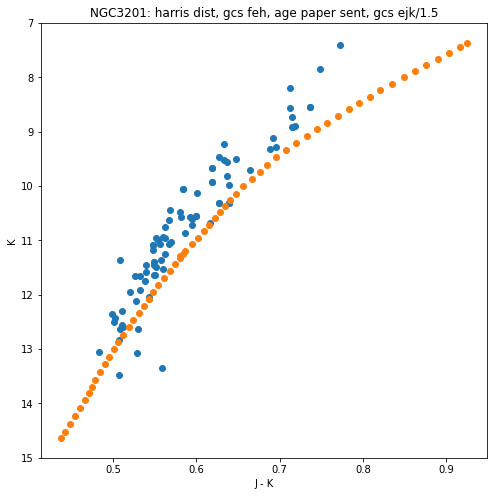

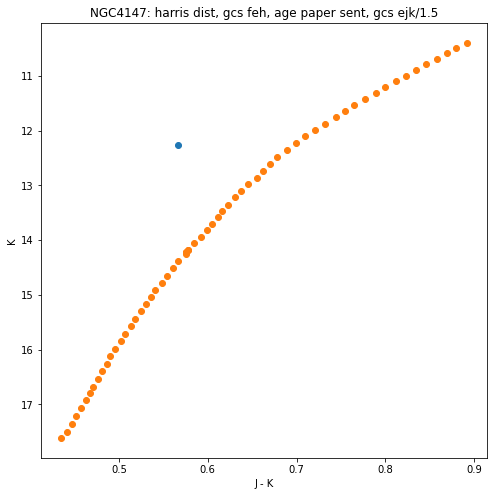

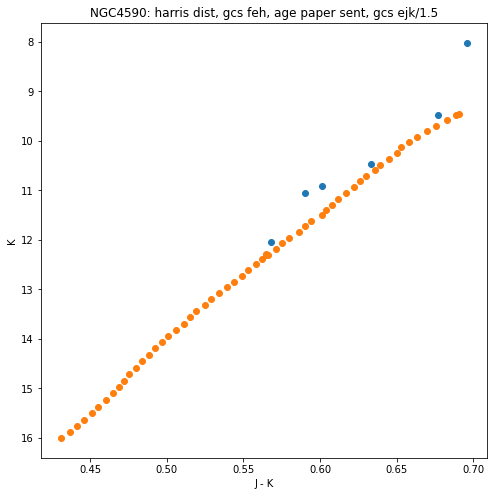

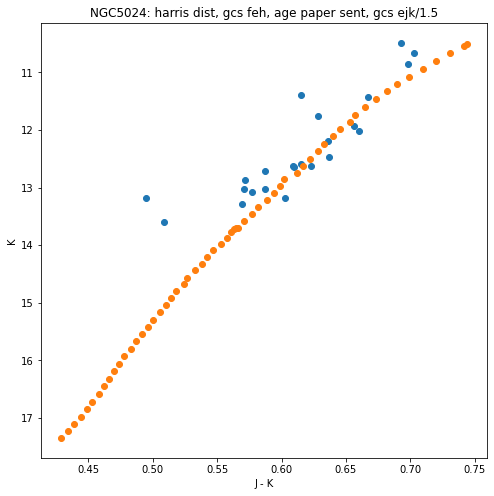

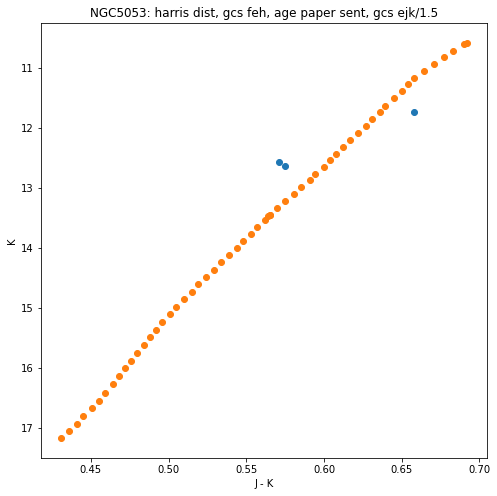

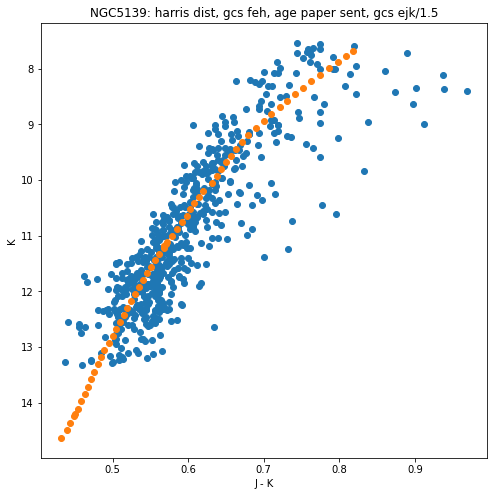

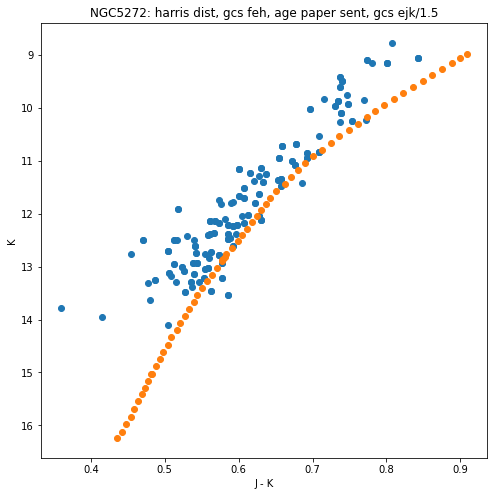

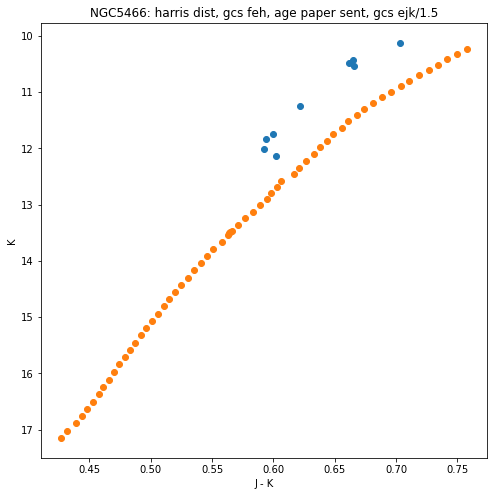

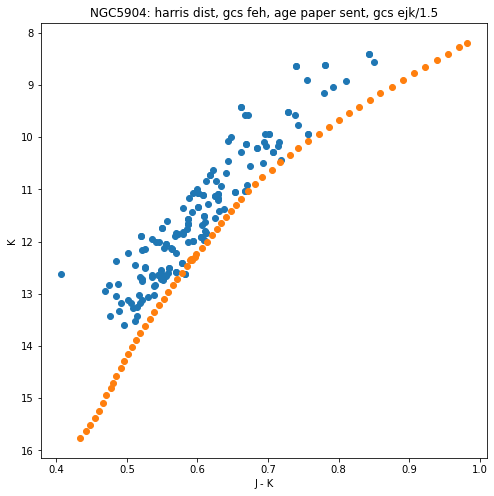

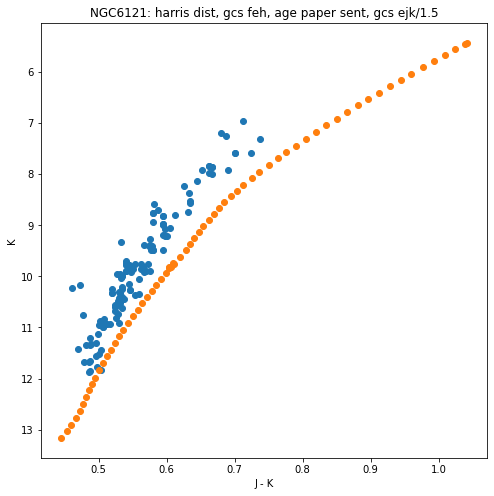

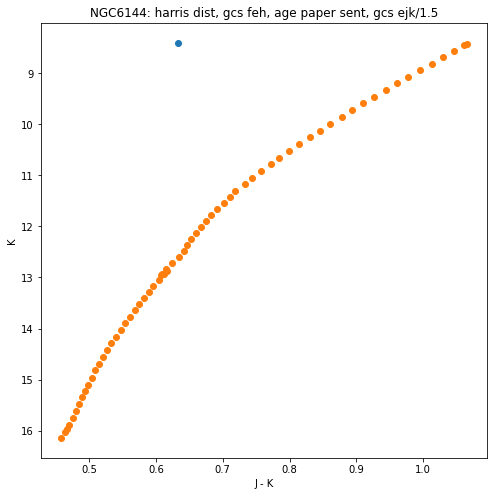

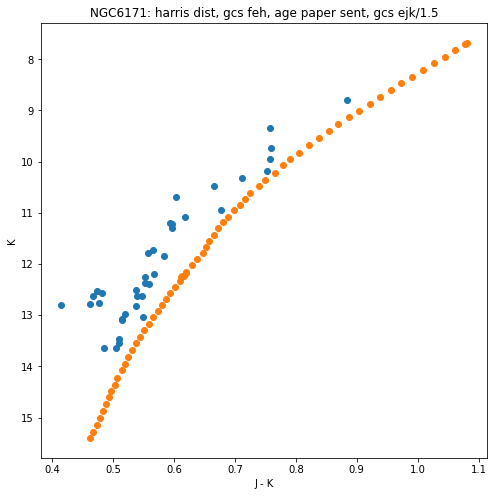

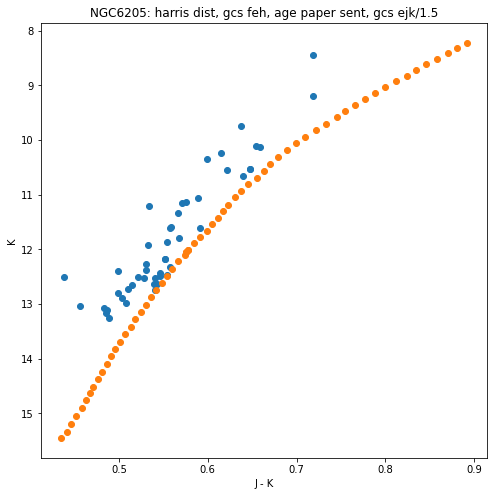

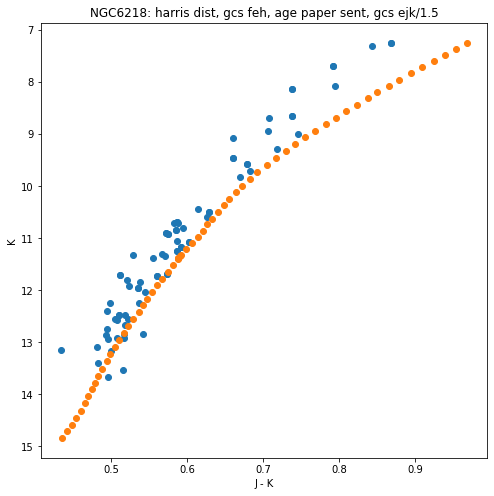

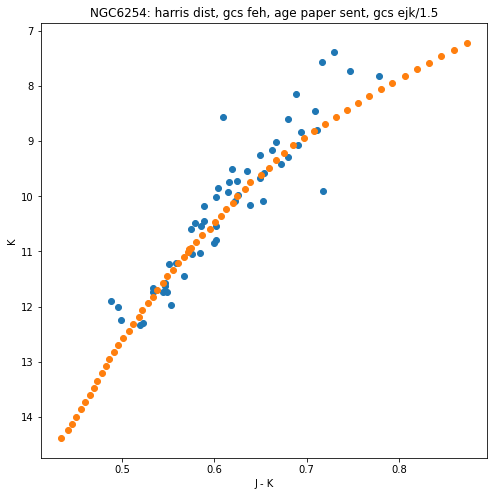

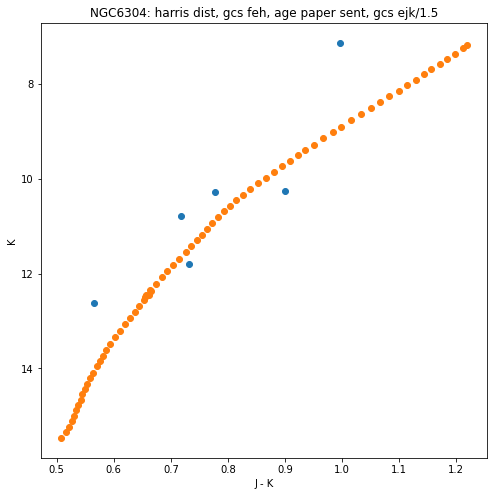

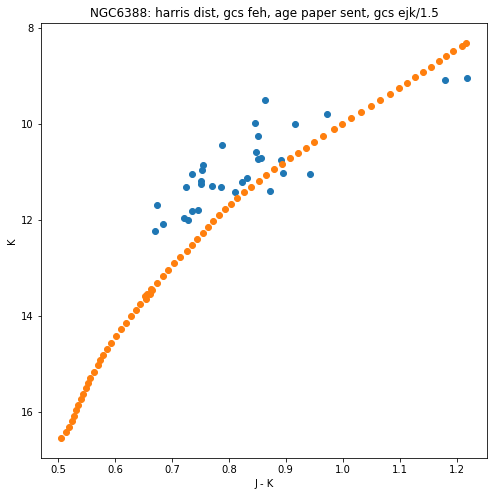

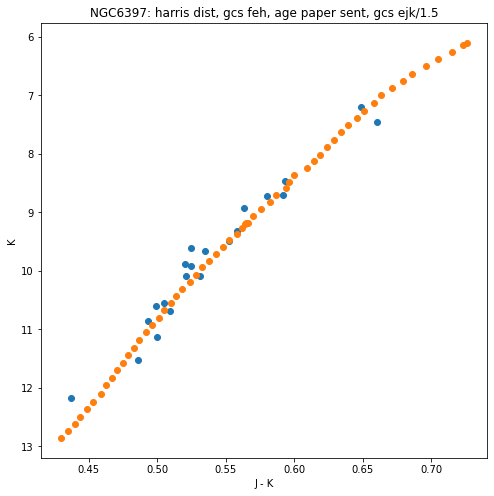

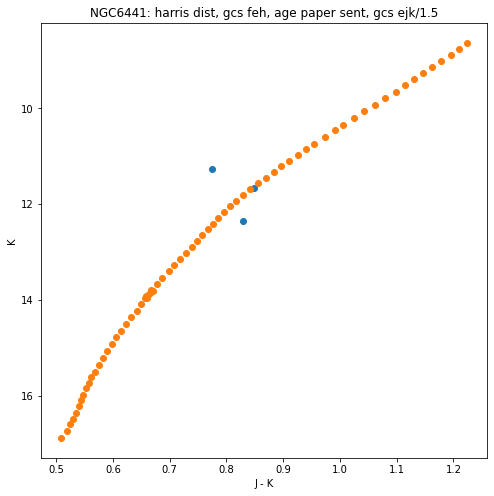

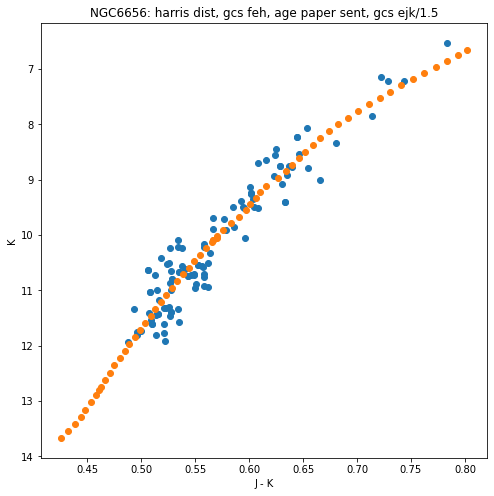

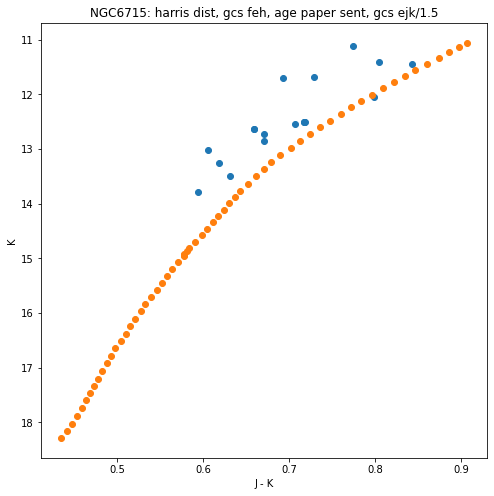

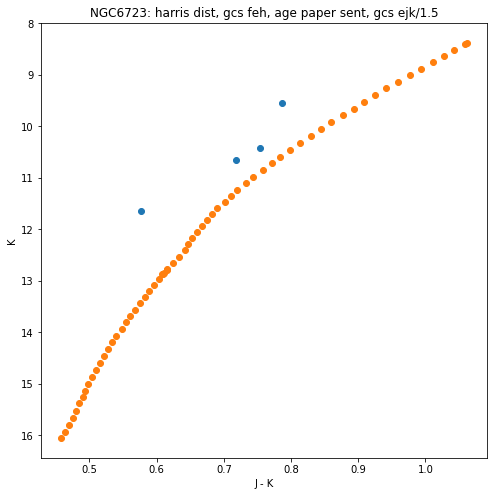

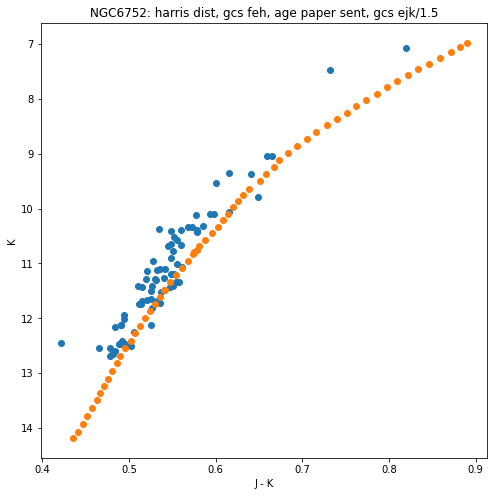

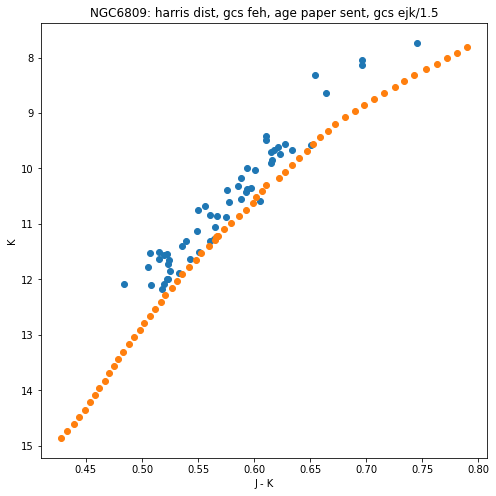

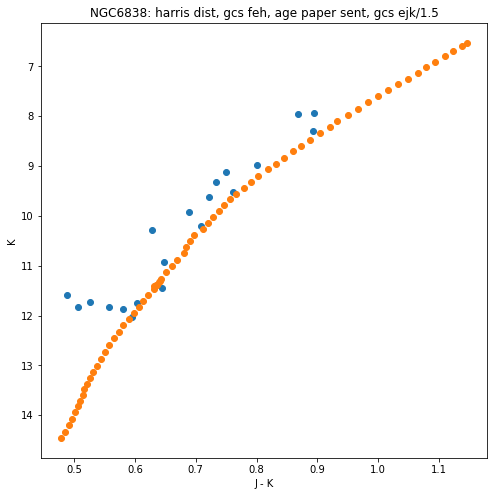

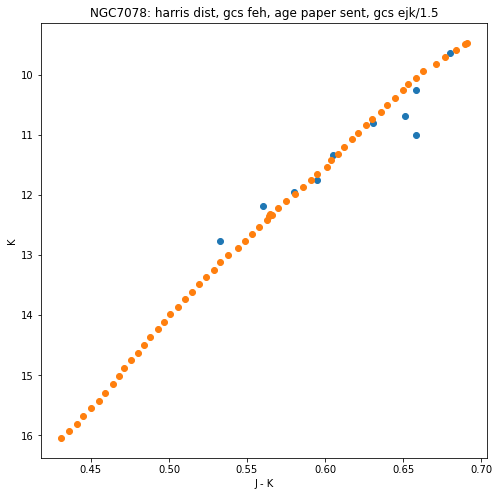

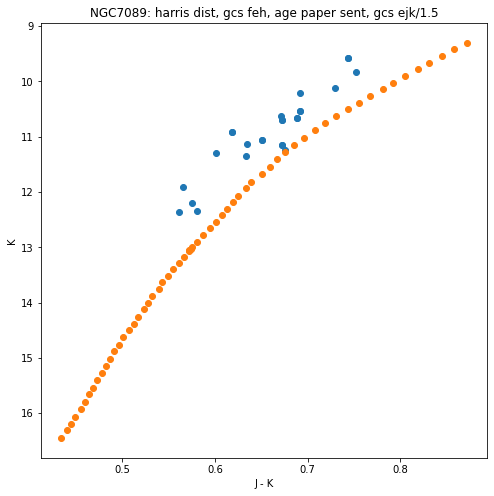

In [7]:
dismod = 5.*np.log10(supp2['harris_dist']*1000)-5.

for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod[i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: harris dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()
    


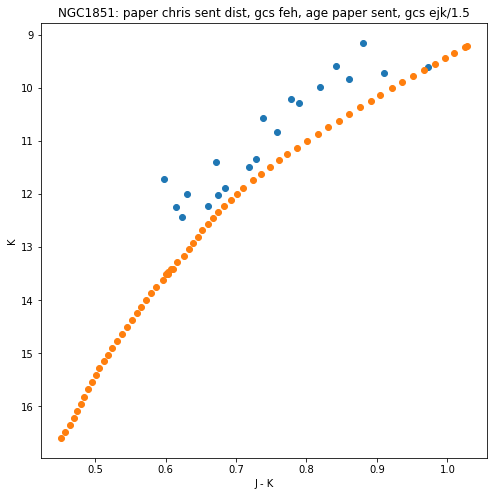

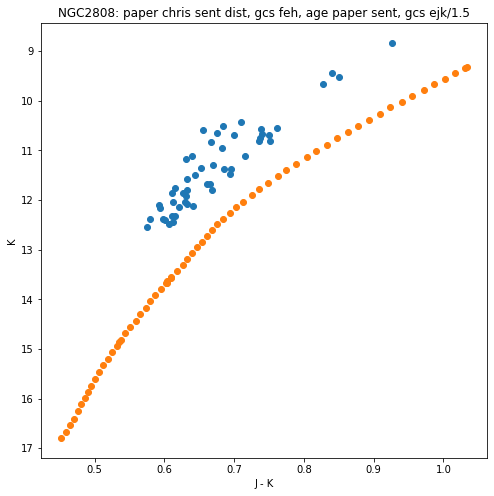

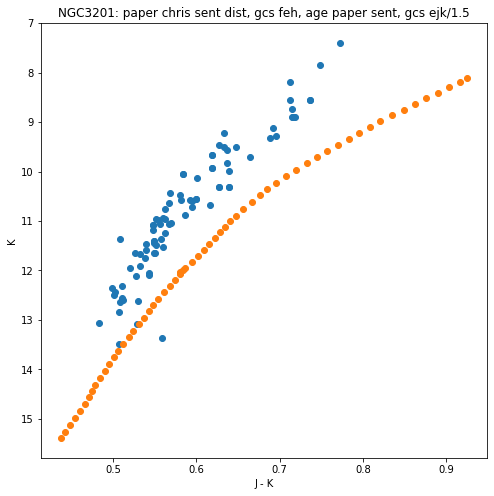

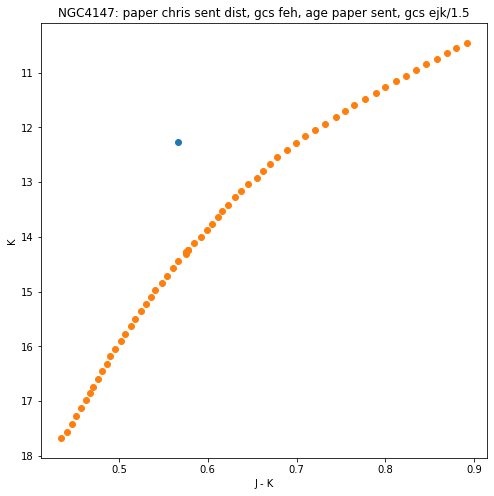

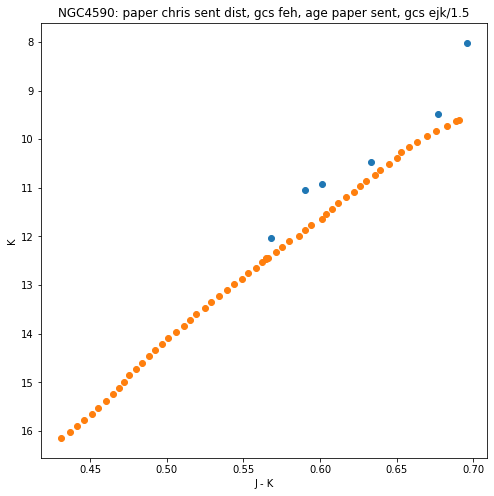

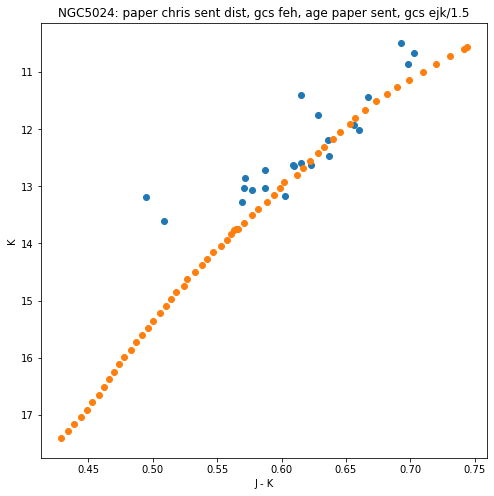

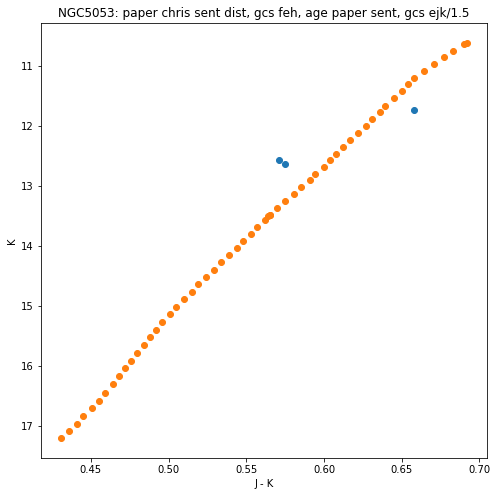

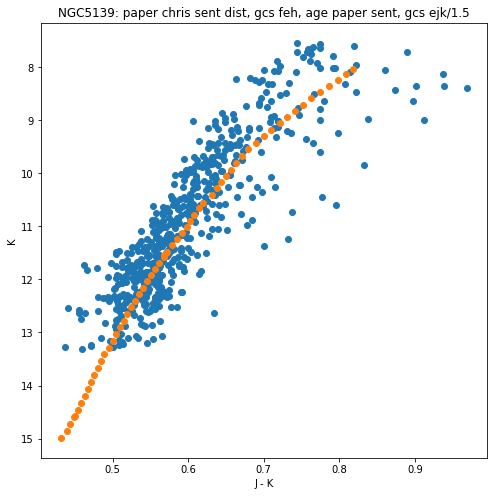

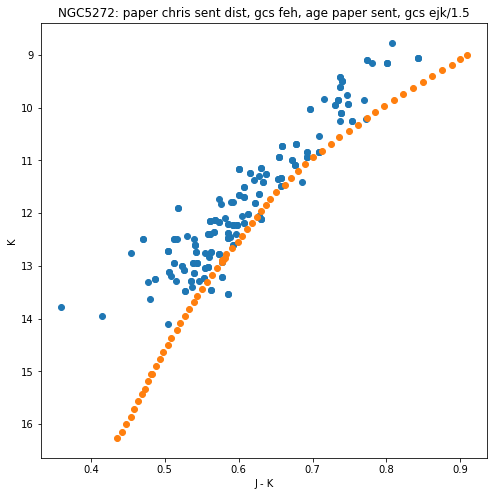

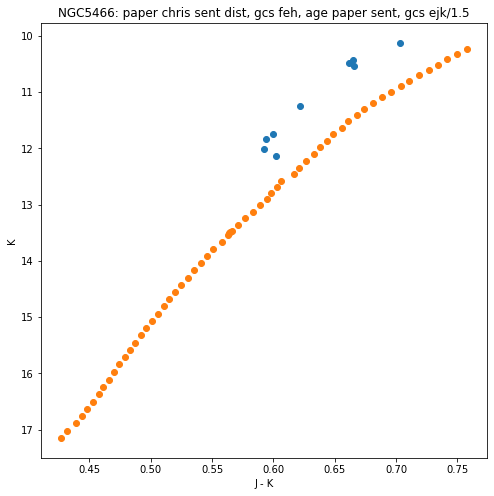

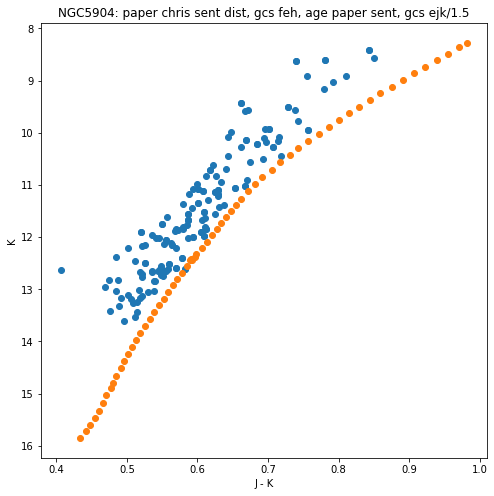

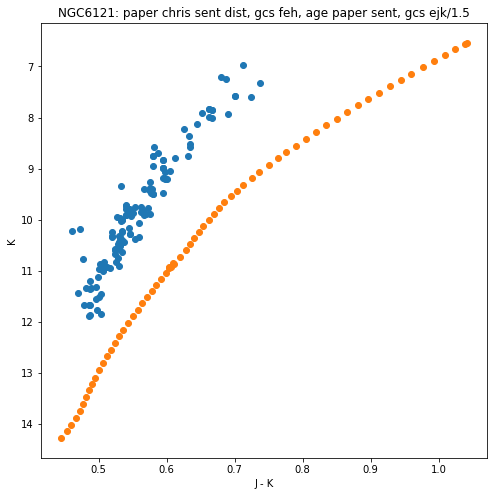

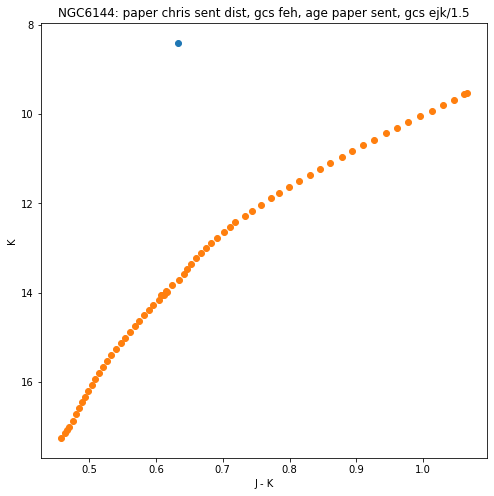

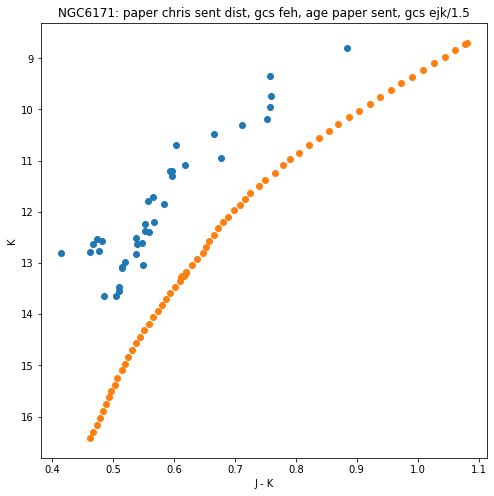

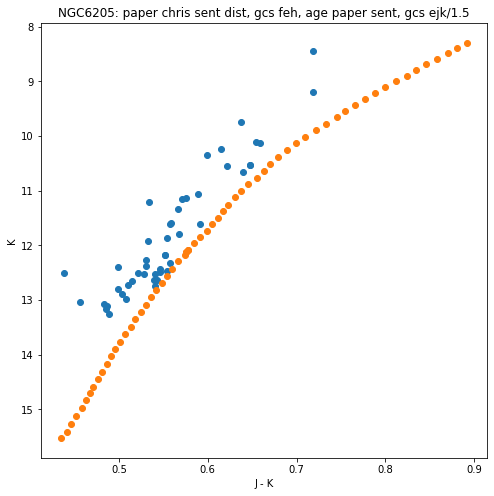

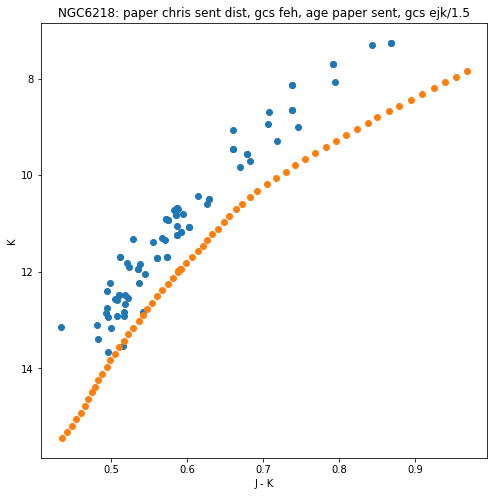

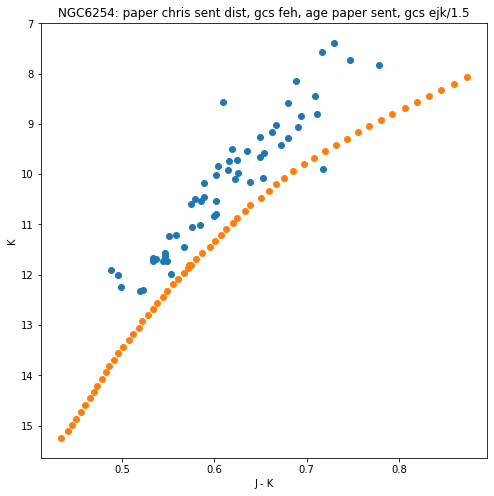

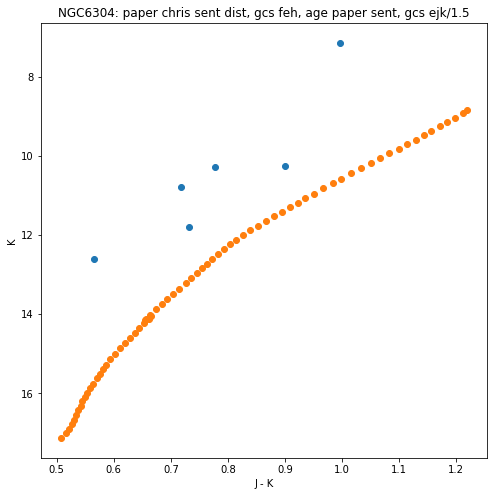

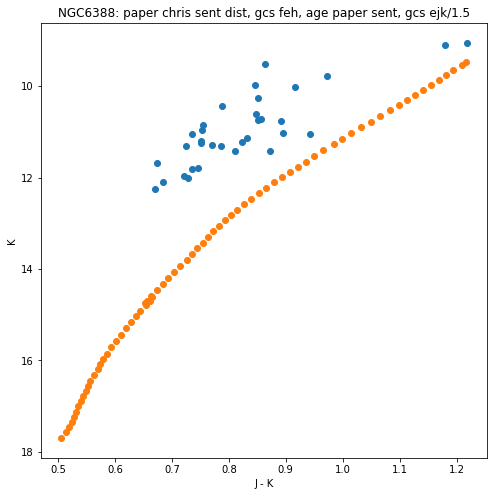

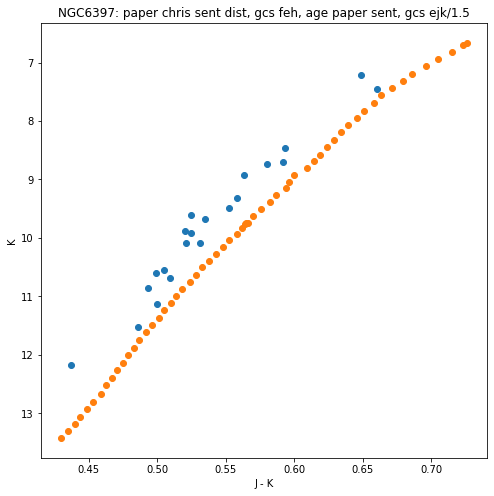

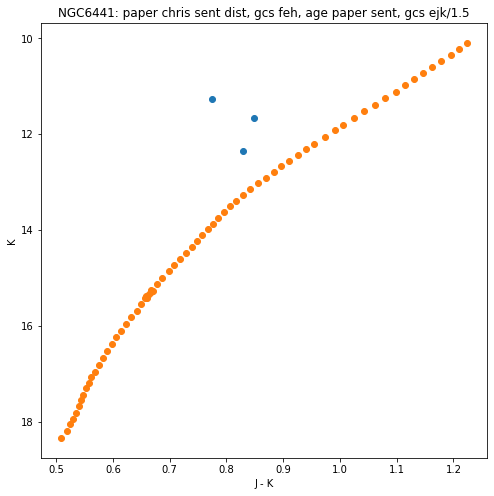

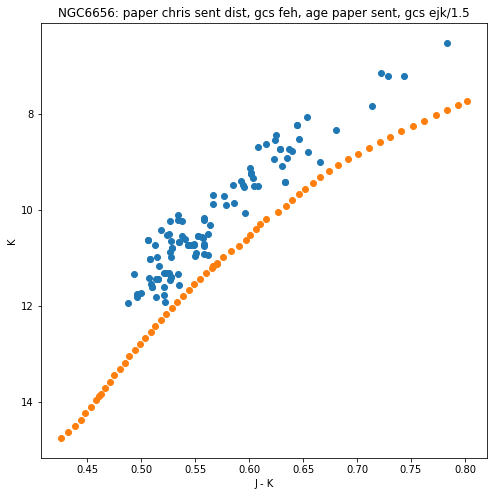

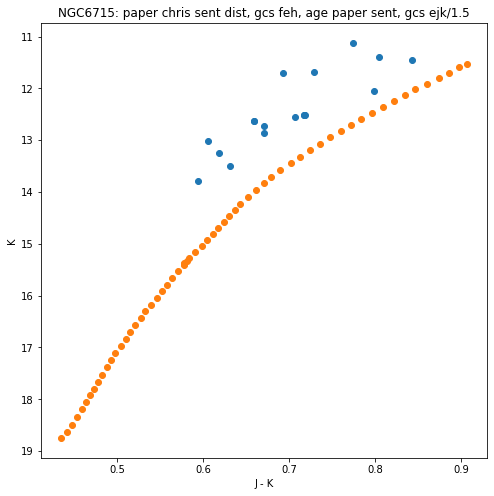

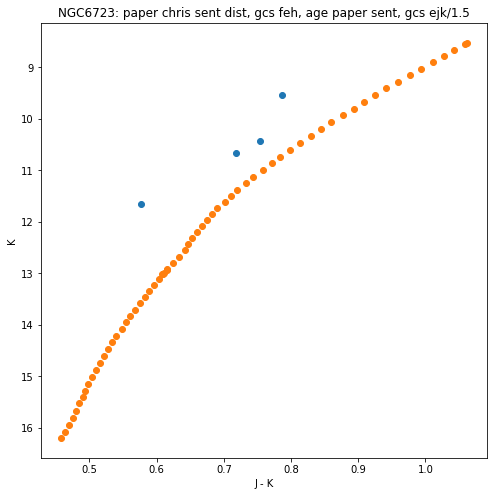

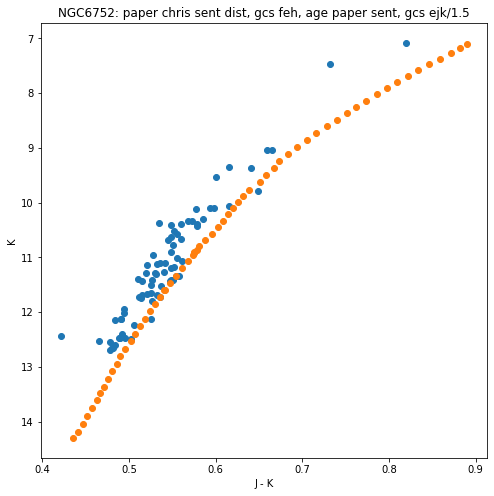

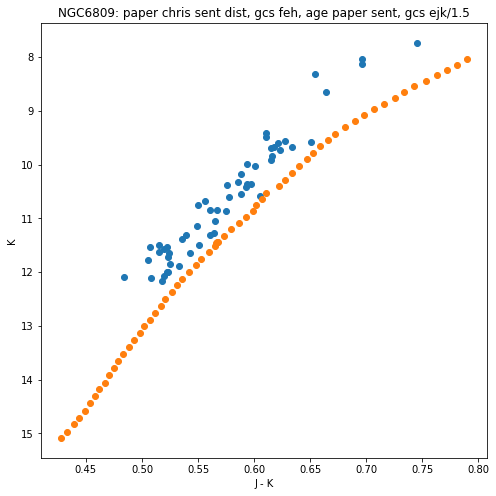

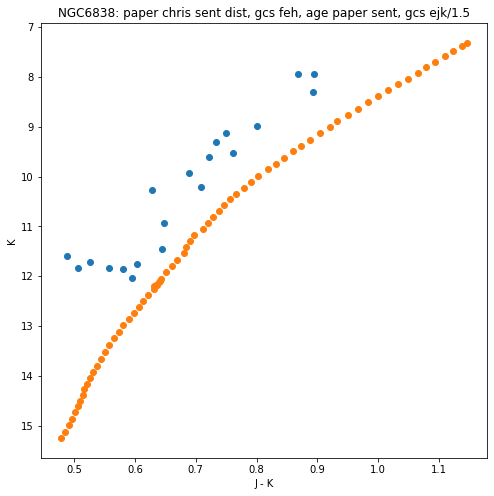

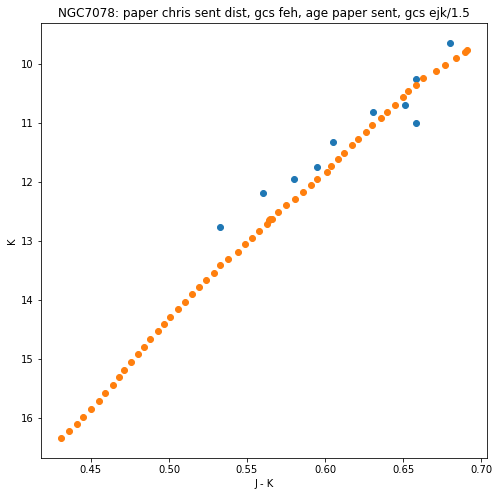

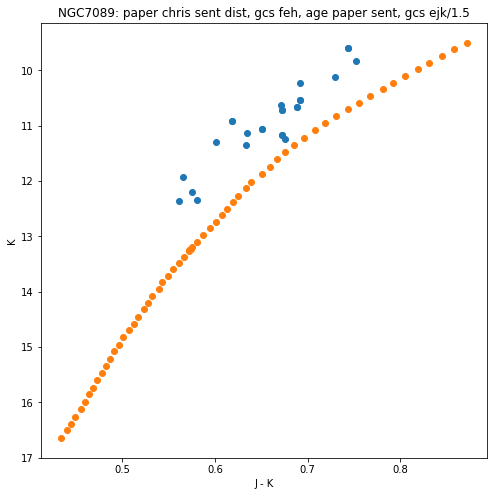

In [8]:
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: paper chris sent dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()

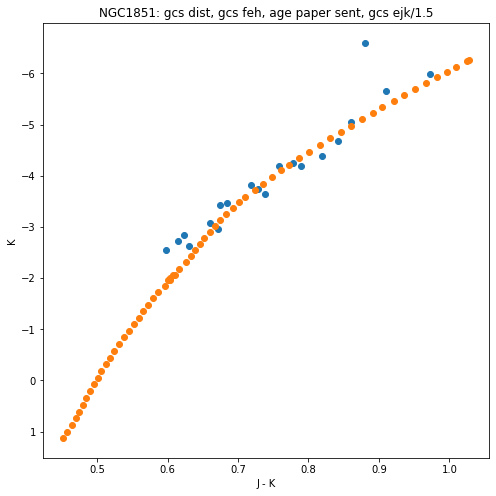

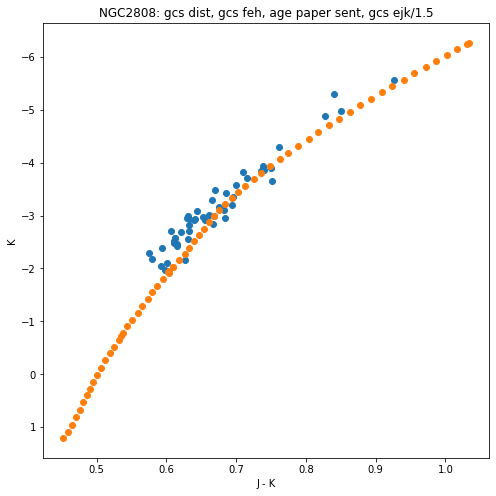

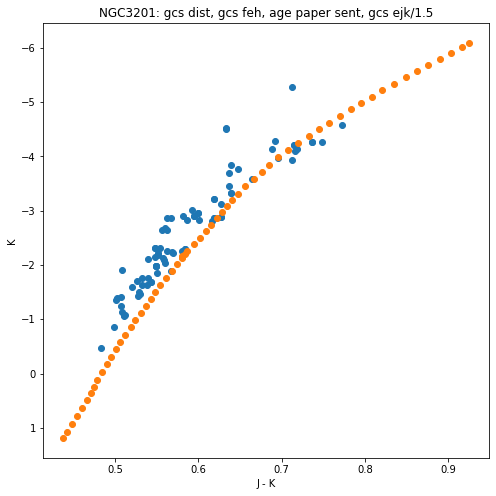

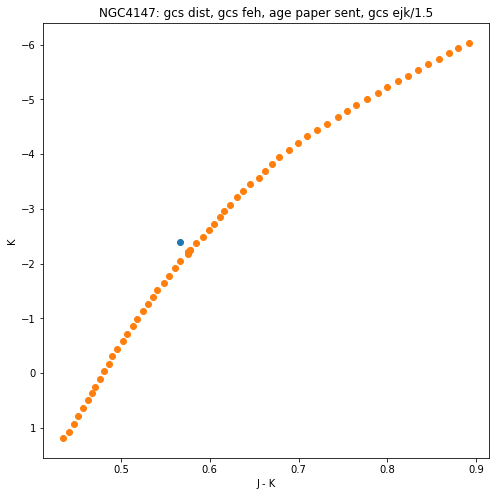

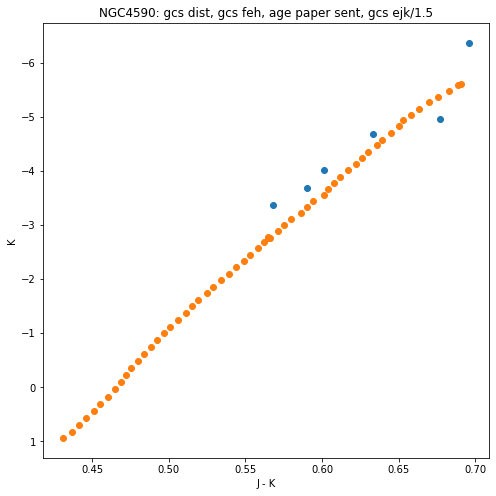

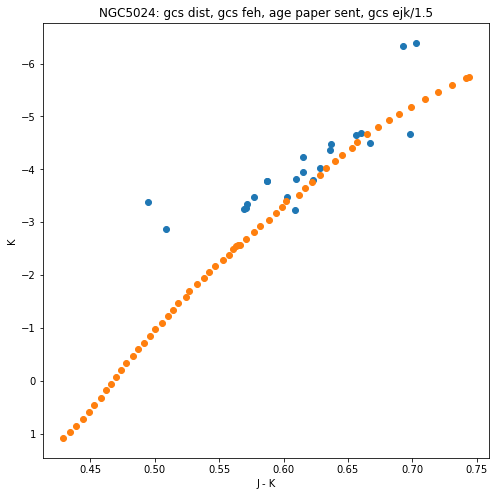

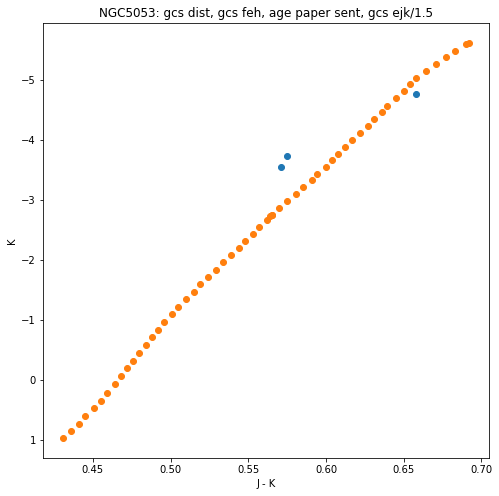

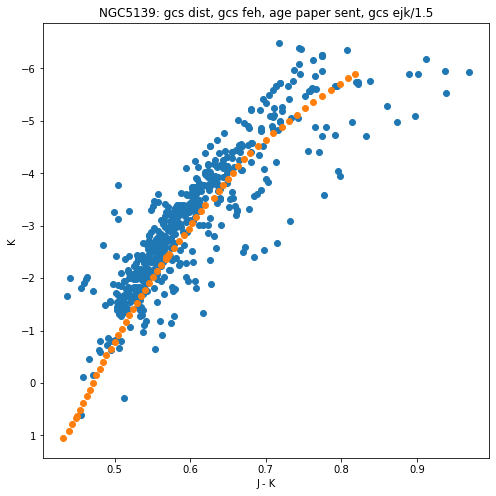

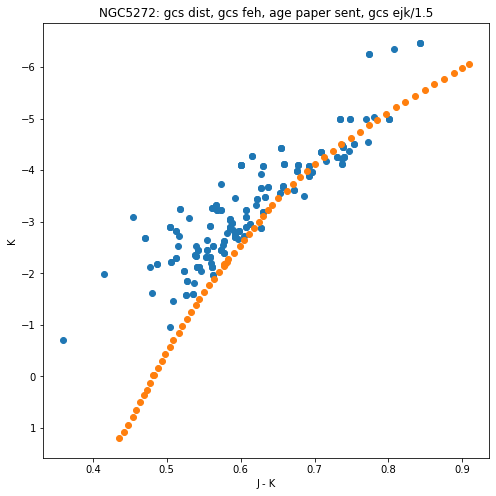

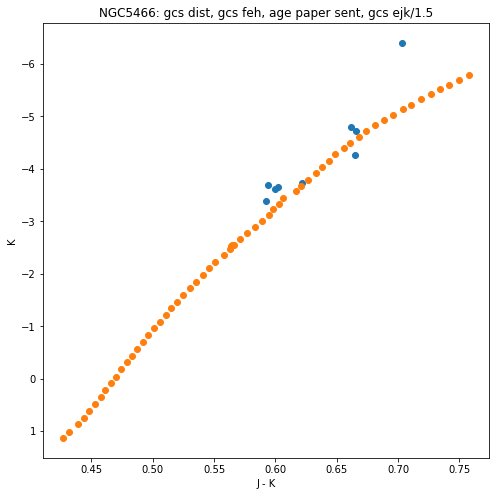

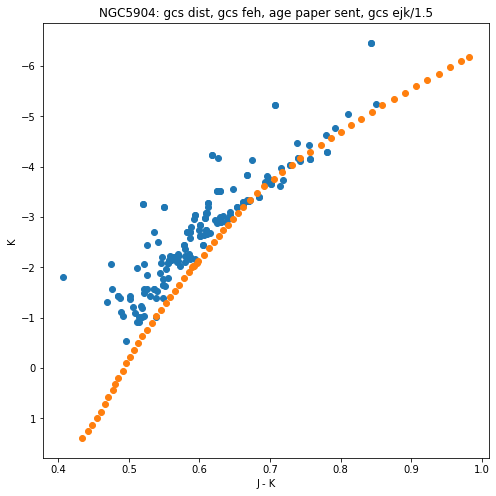

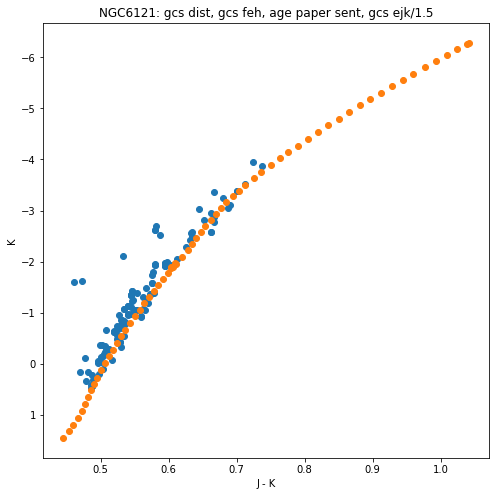

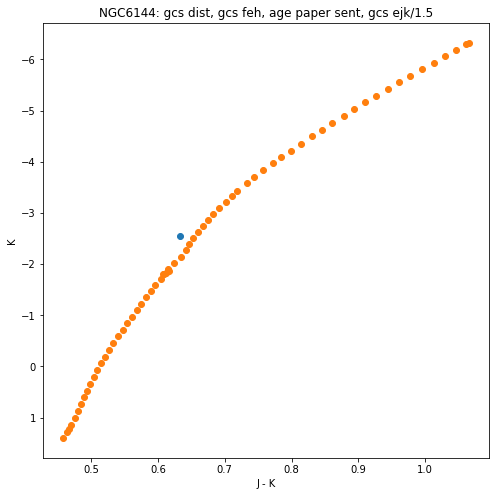

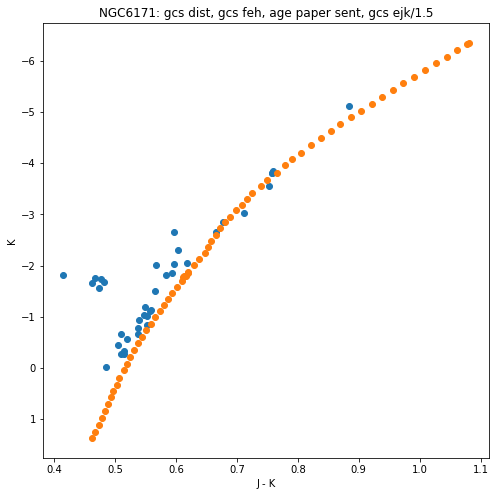

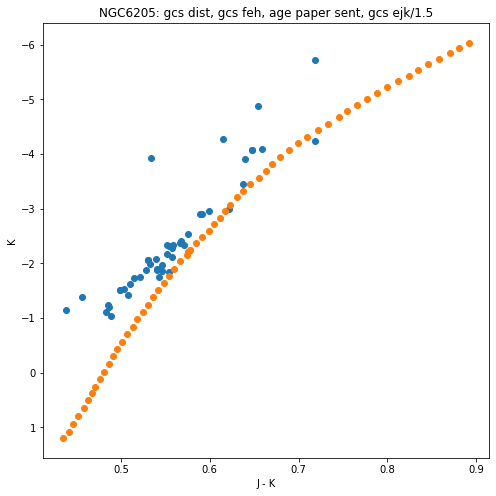

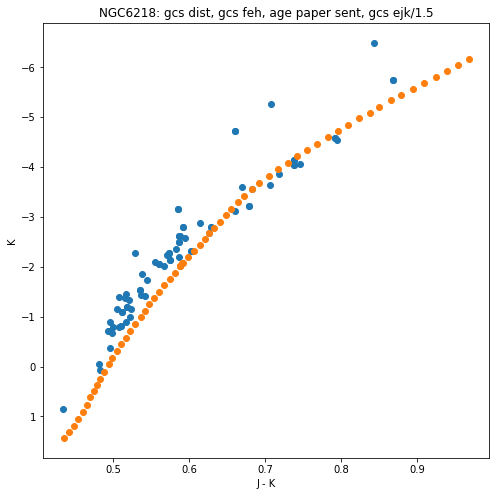

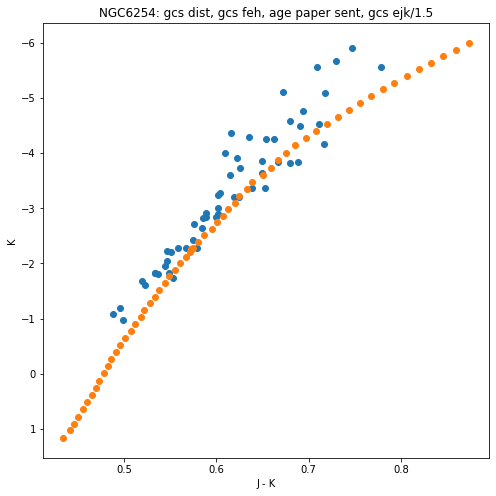

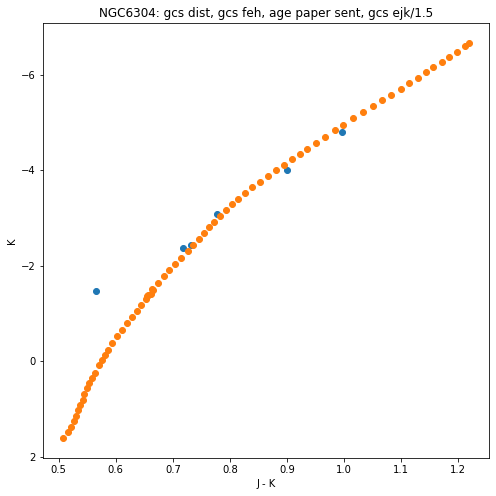

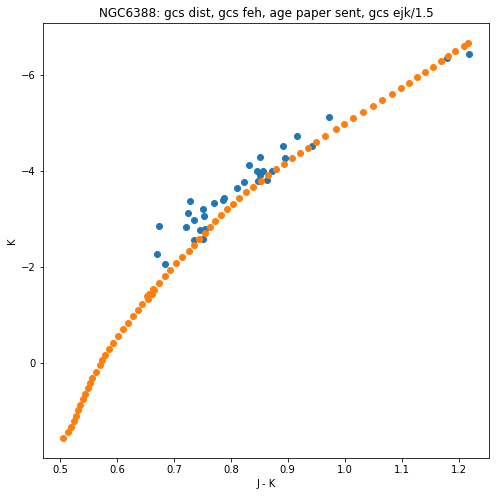

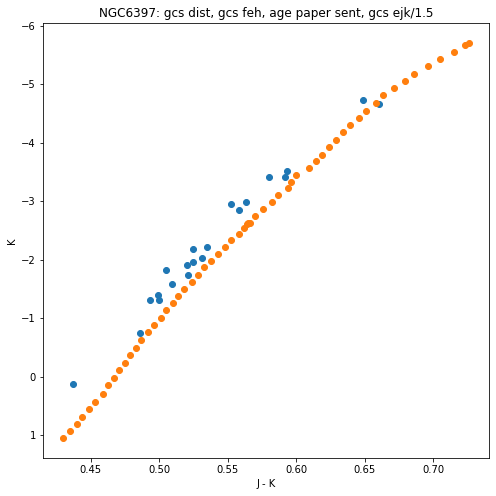

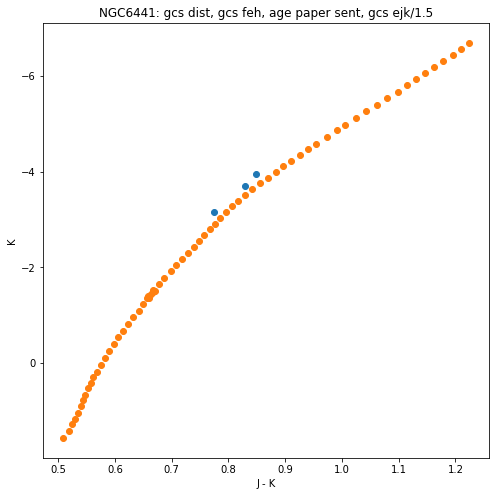

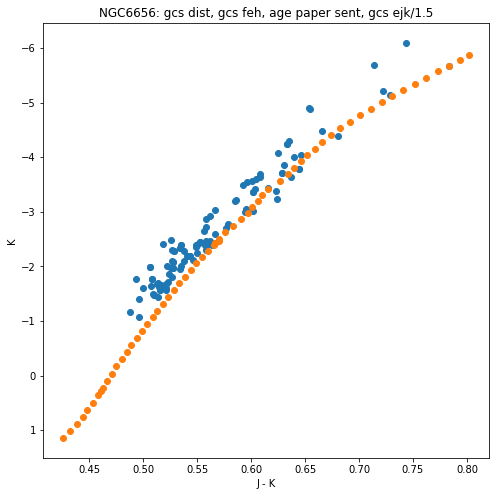

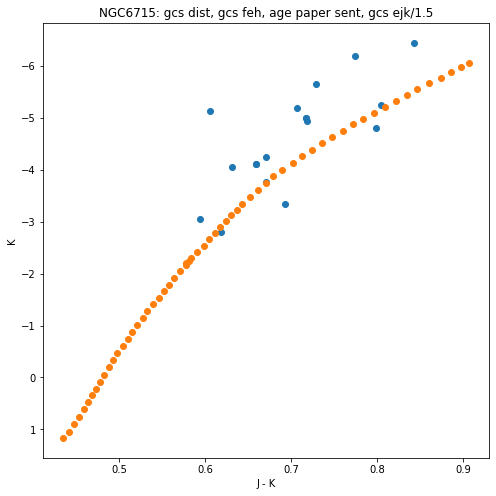

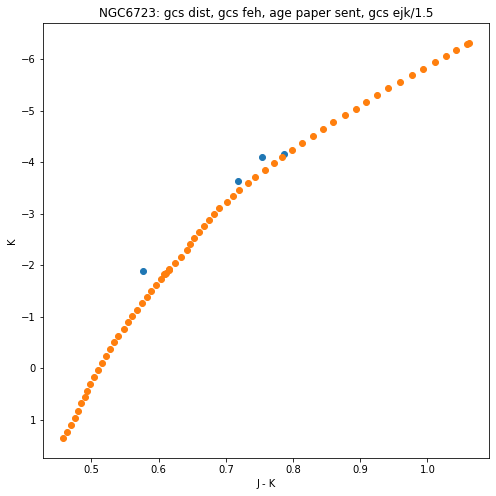

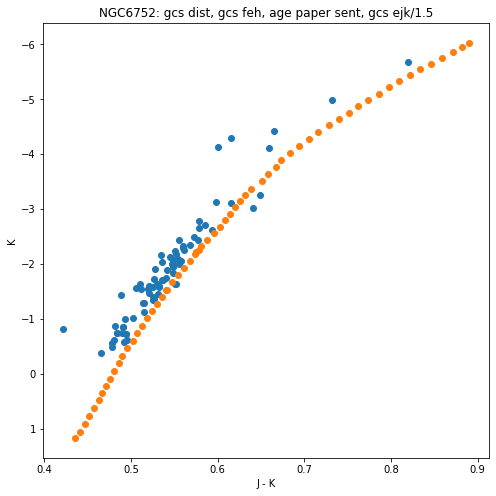

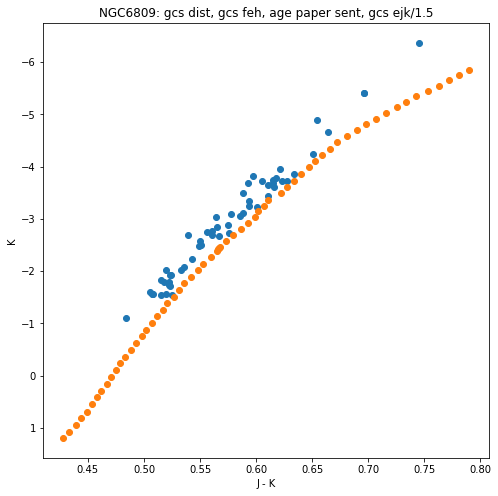

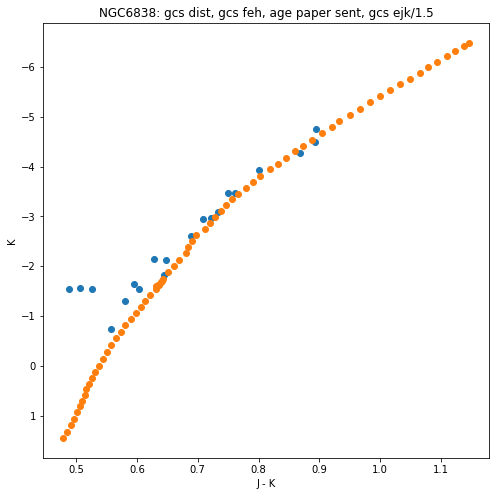

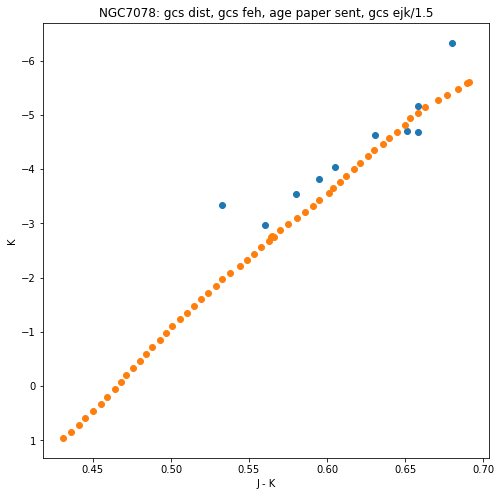

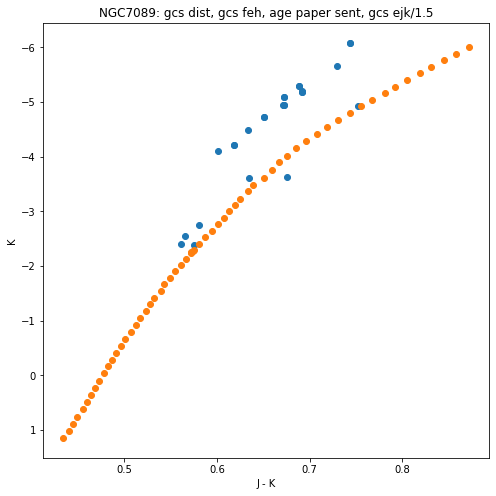

In [9]:
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    dismod = 5.*np.log10(gcs['distmed'][clus]*1000)-5
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dismod*0.99)
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: gcs dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()

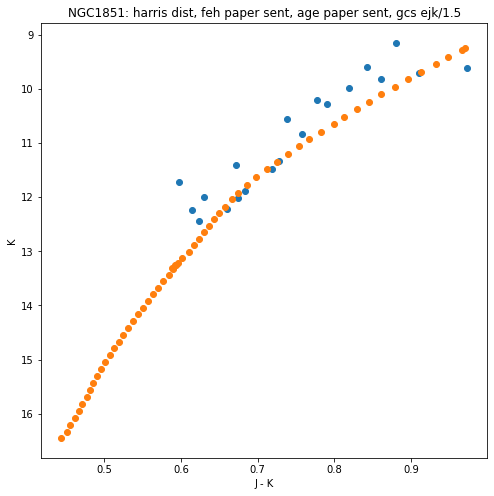

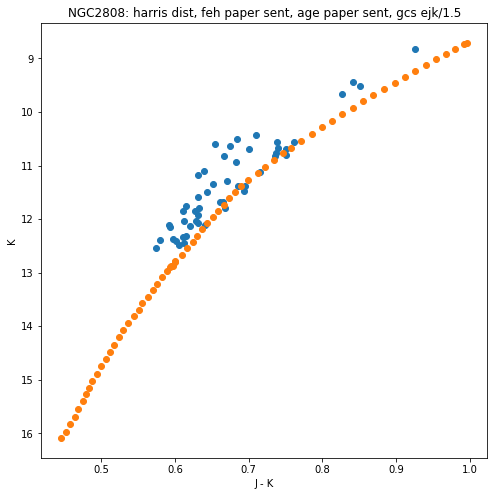

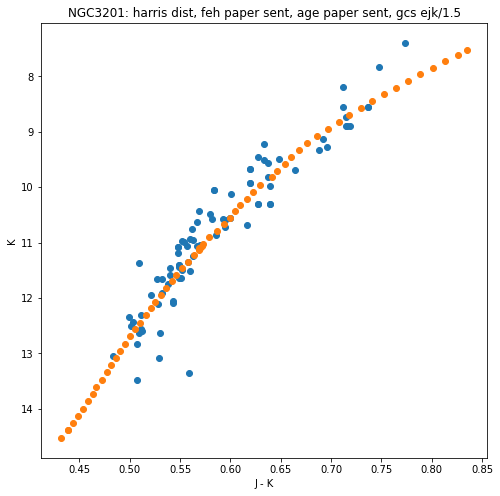

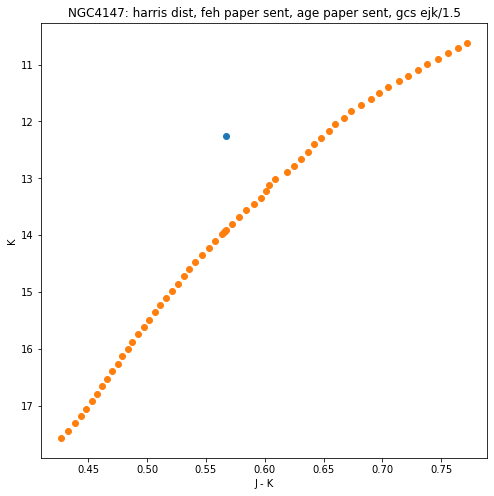

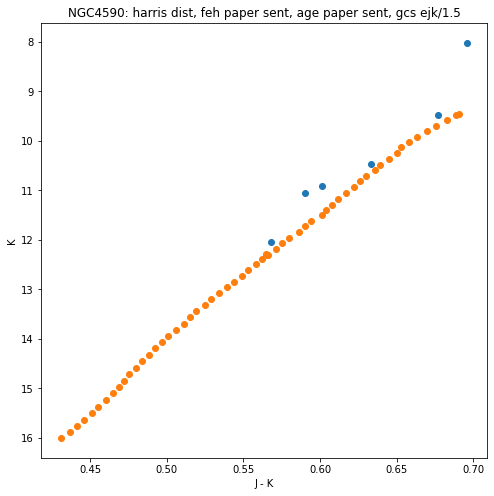

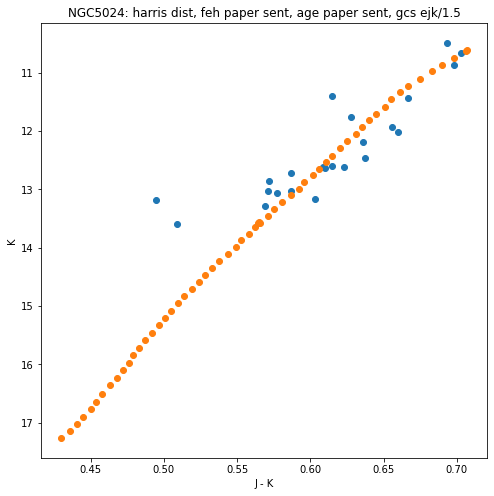

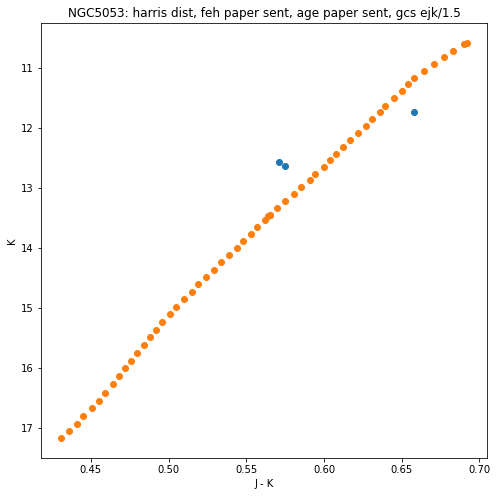

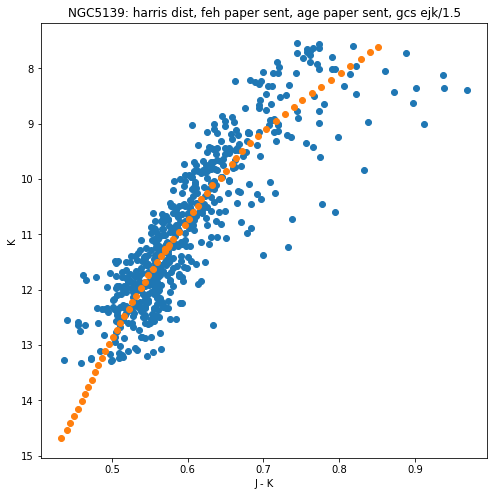

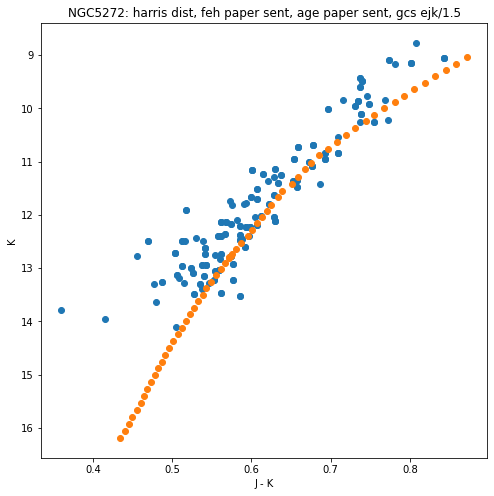

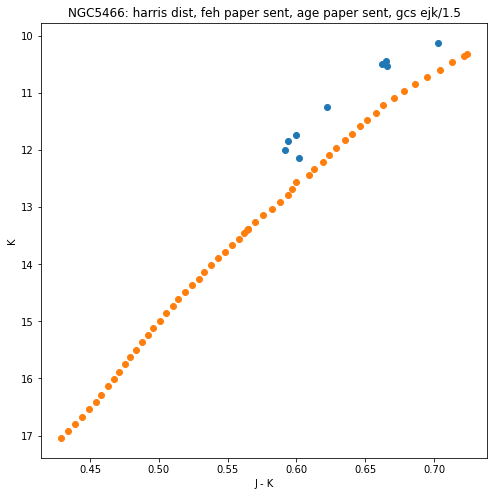

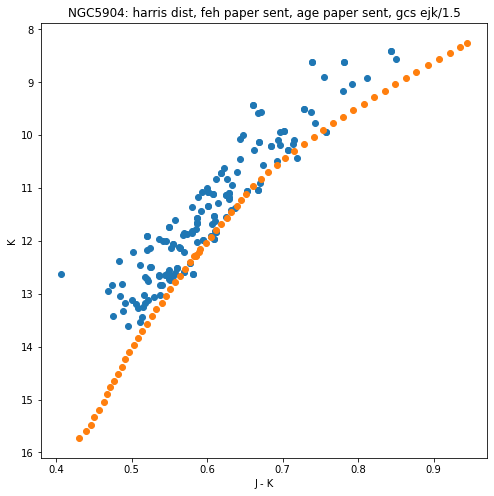

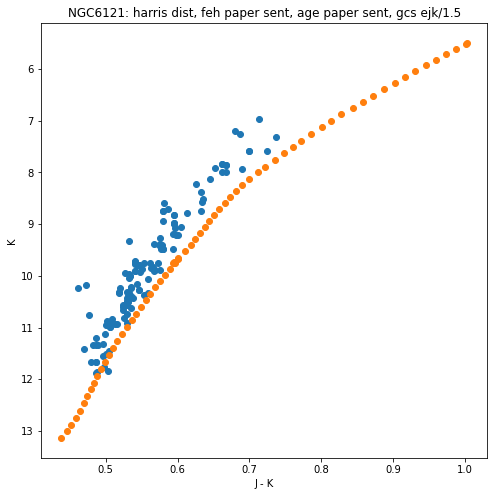

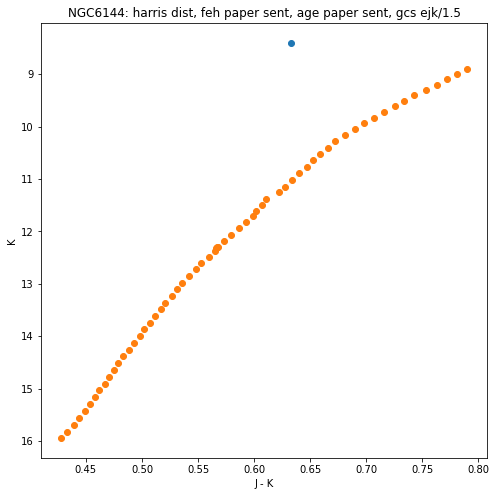

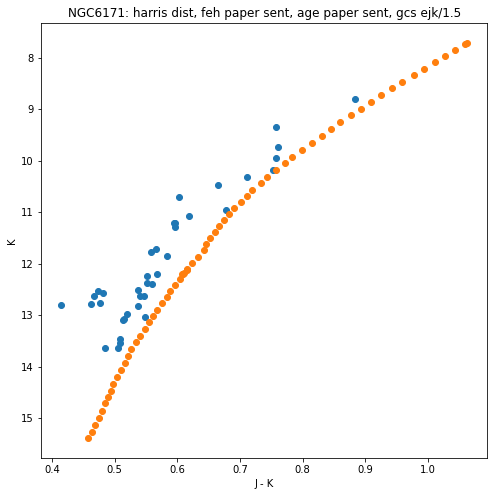

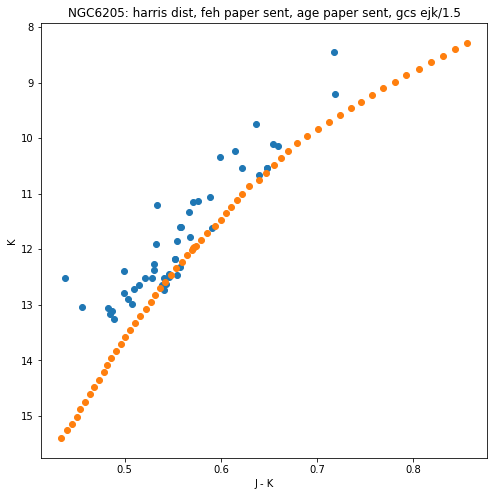

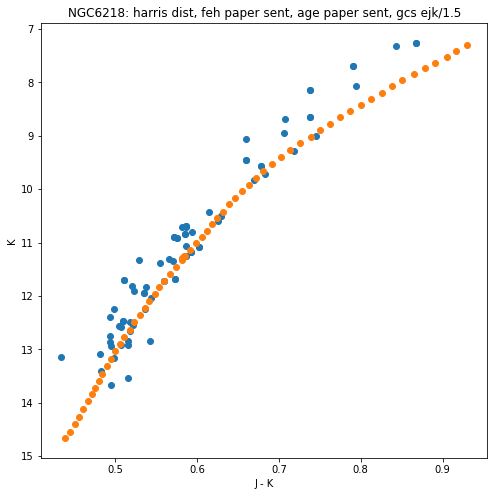

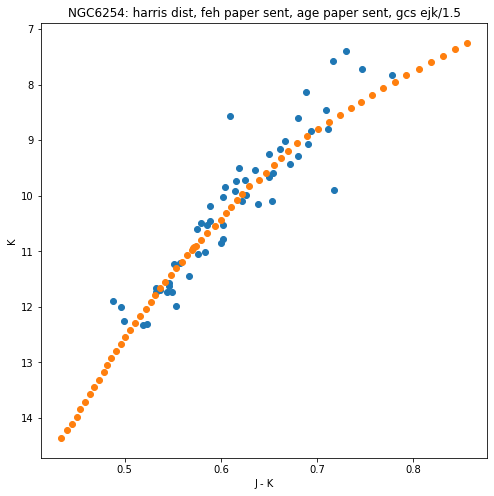

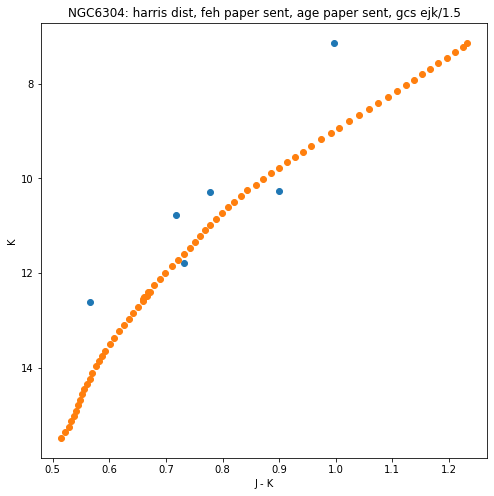

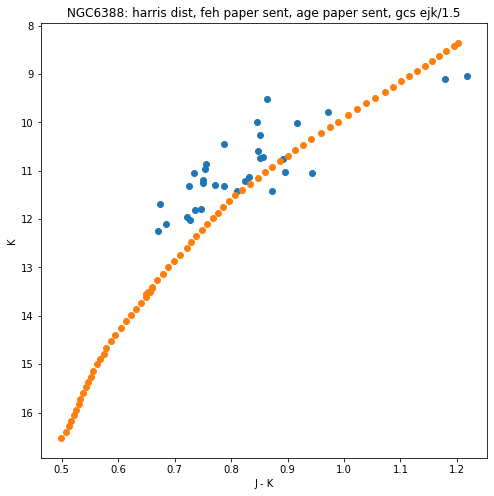

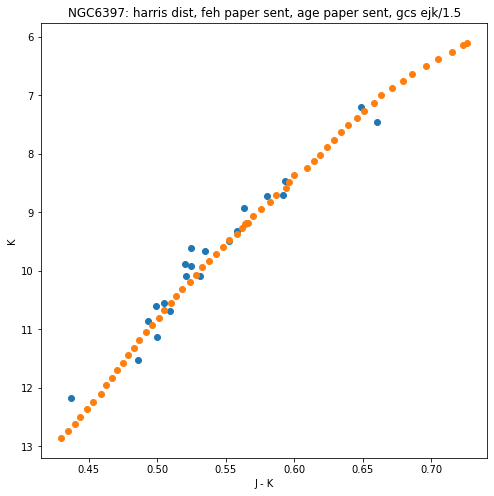

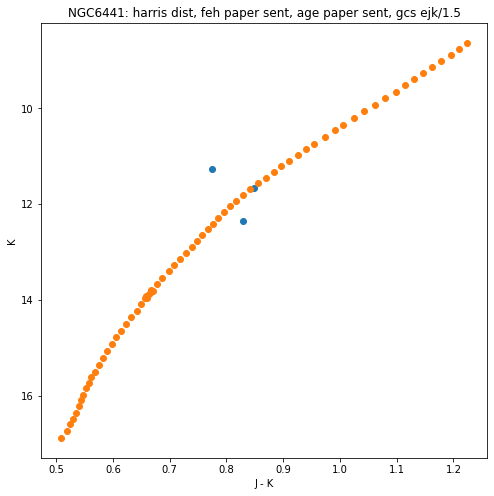

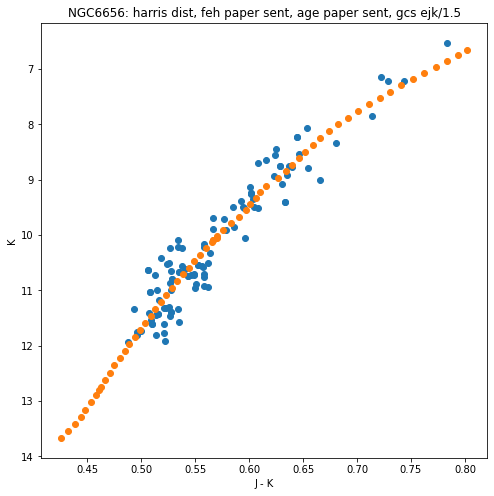

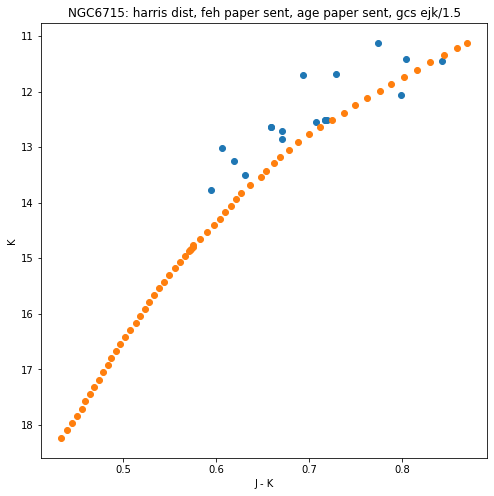

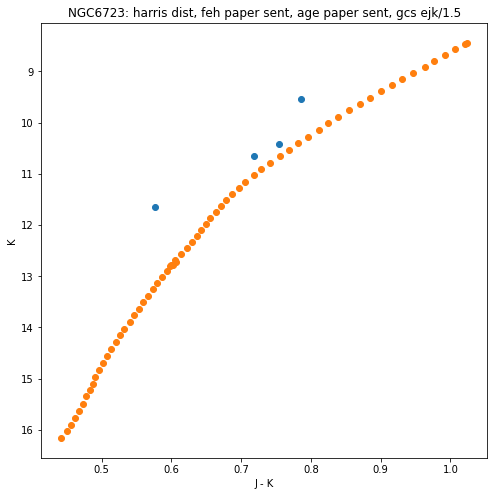

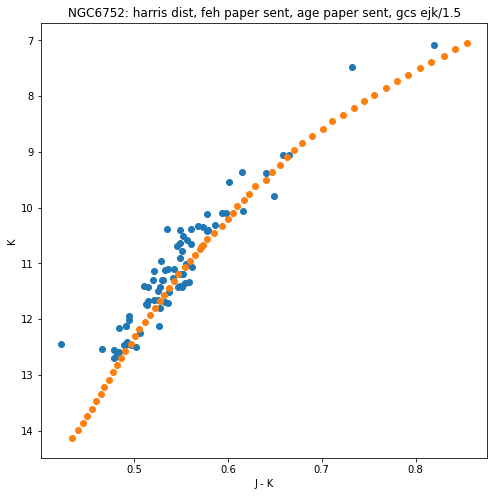

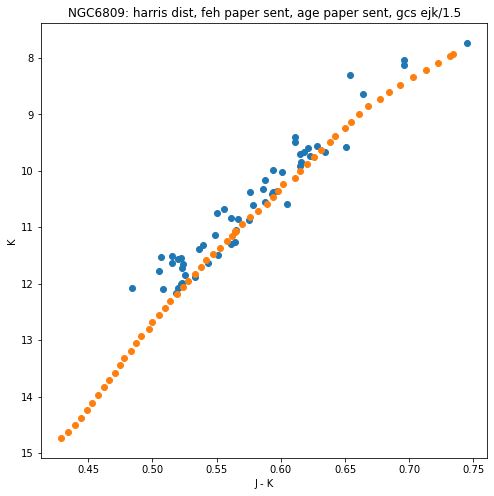

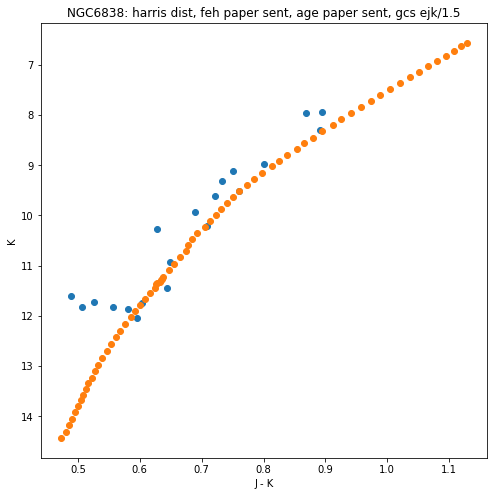

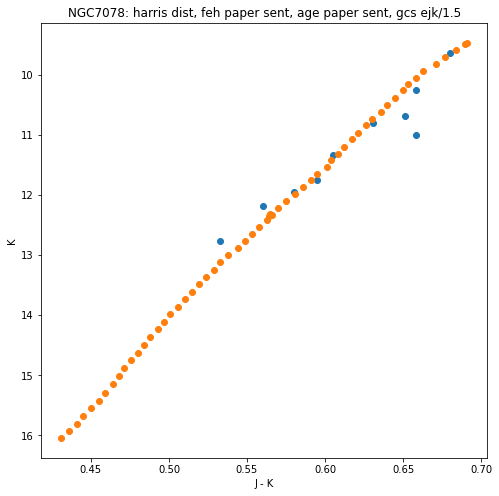

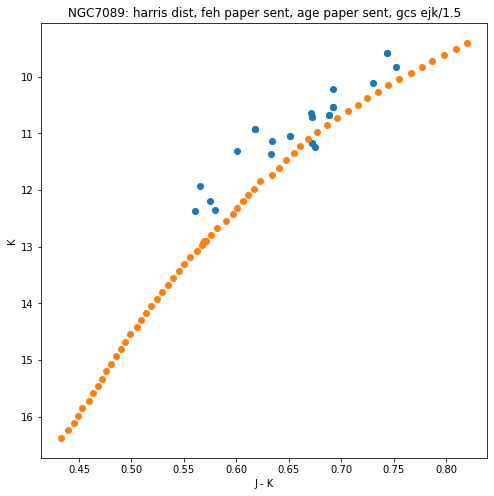

#####################################################################################################


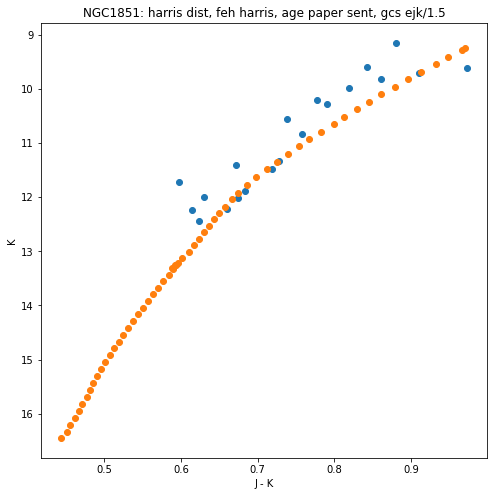

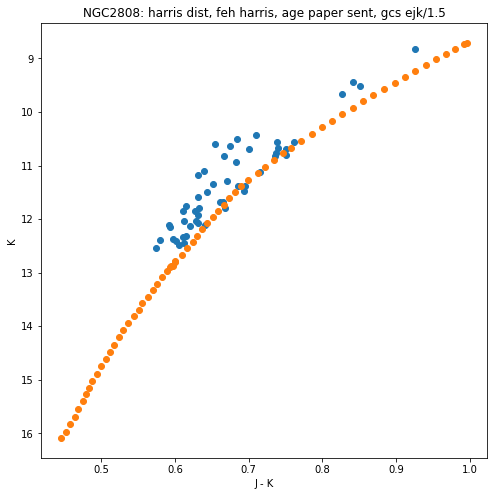

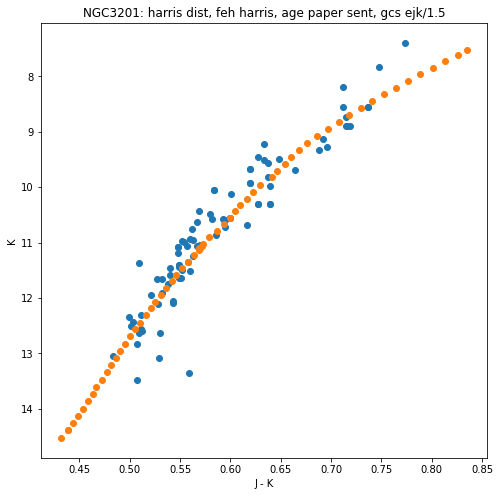

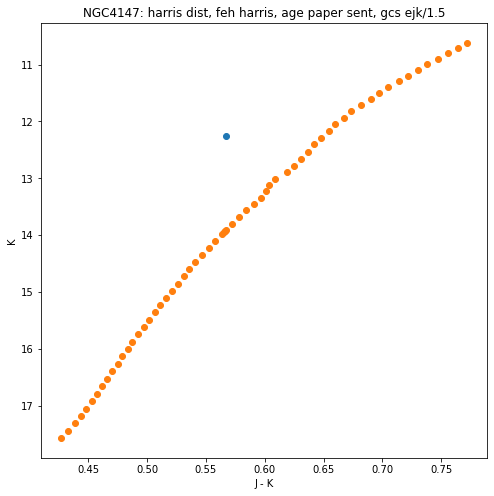

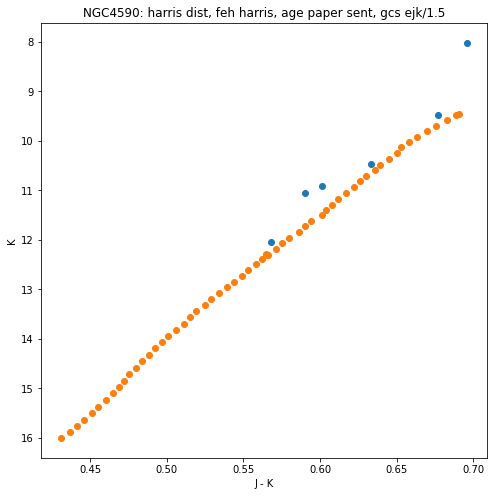

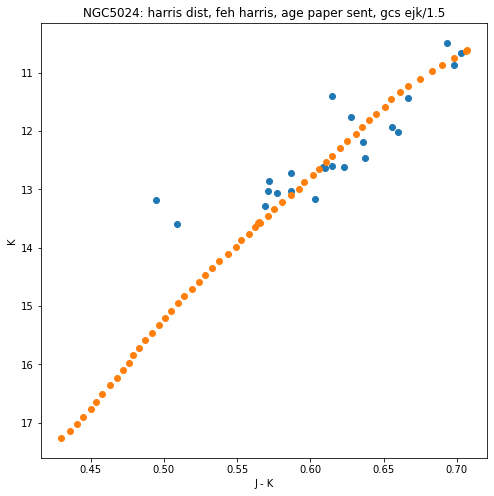

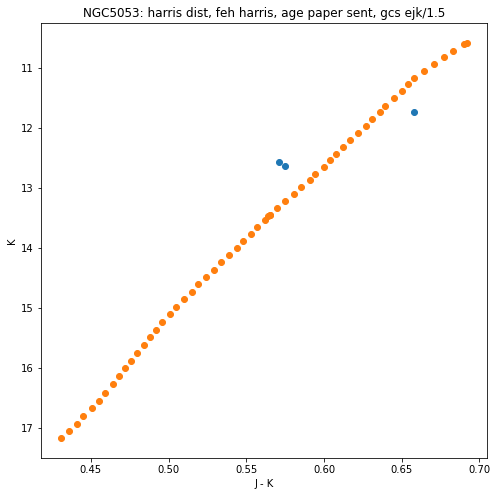

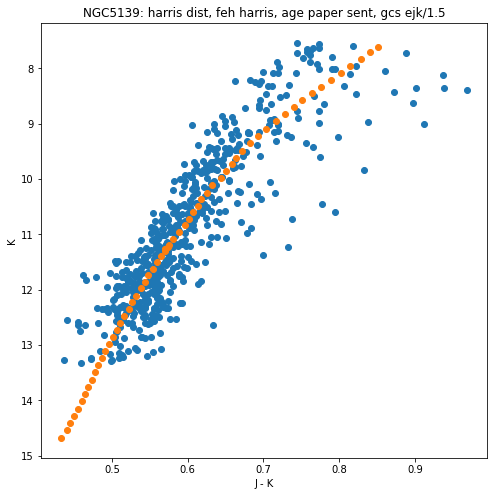

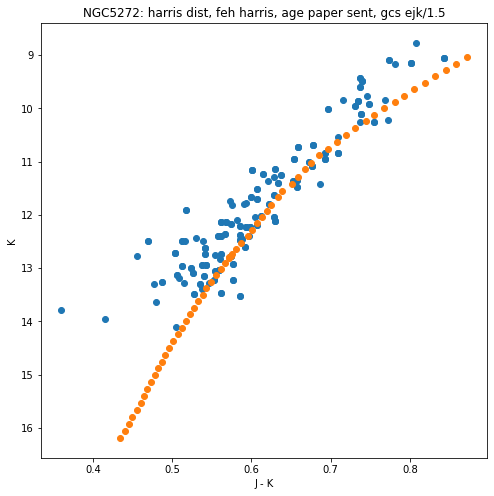

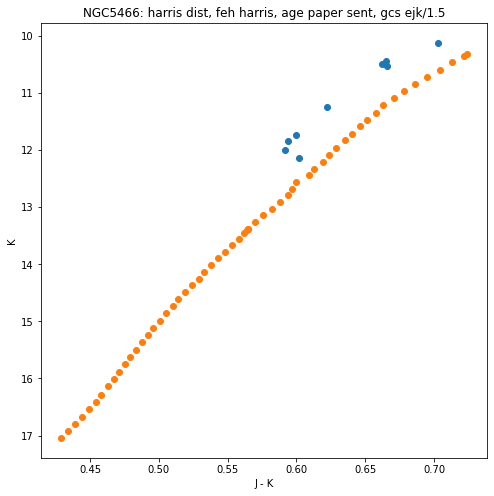

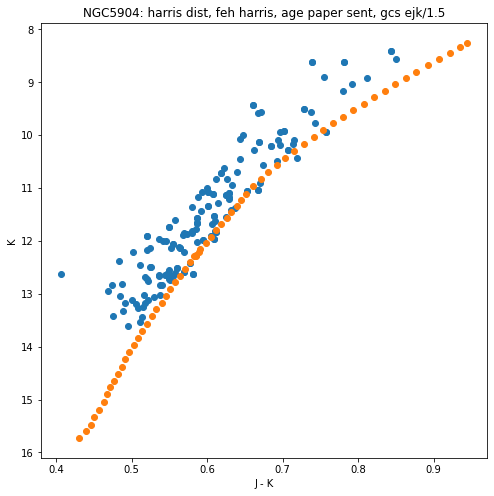

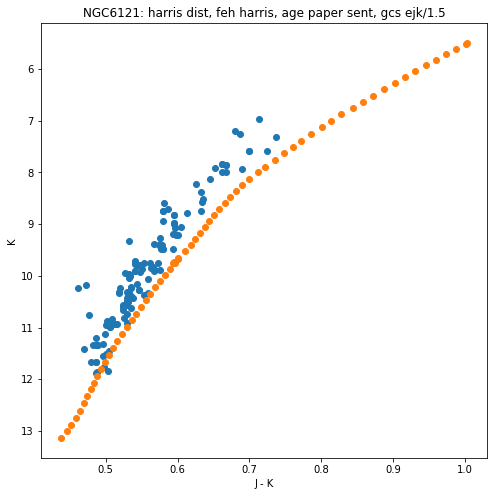

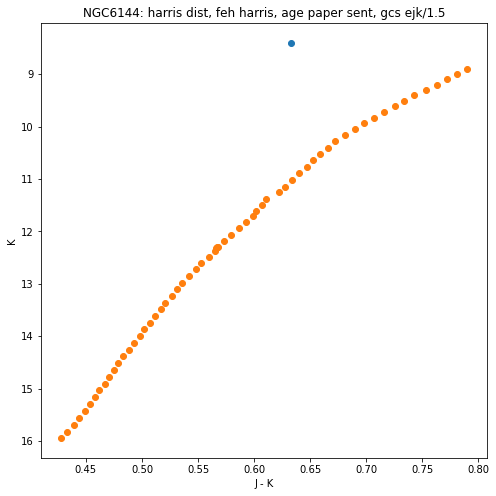

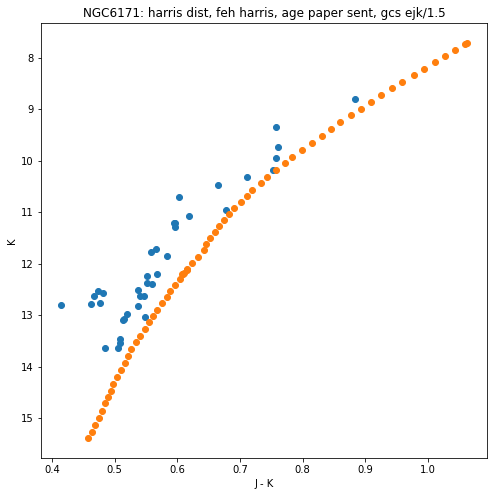

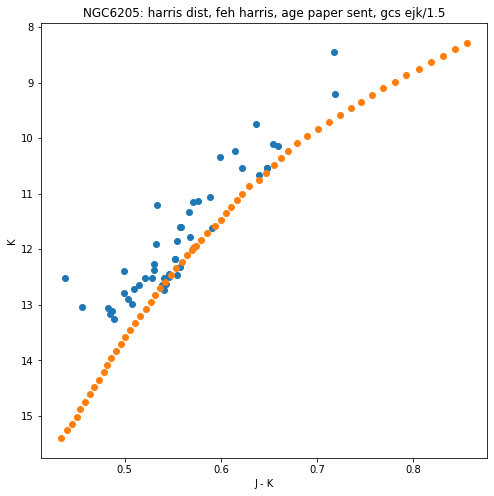

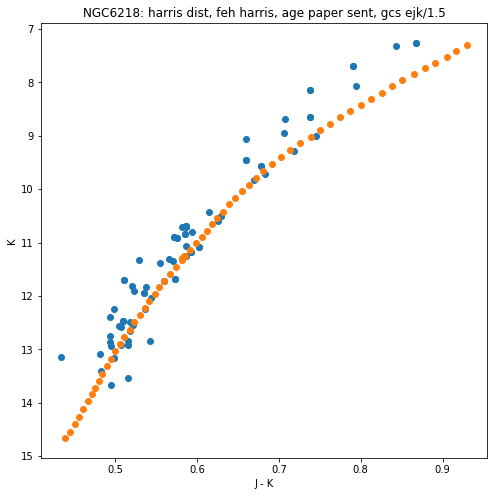

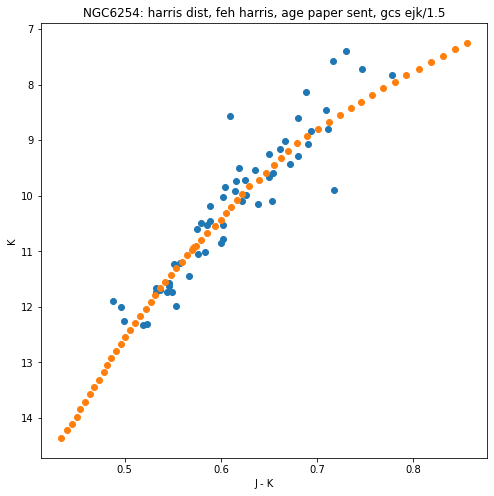

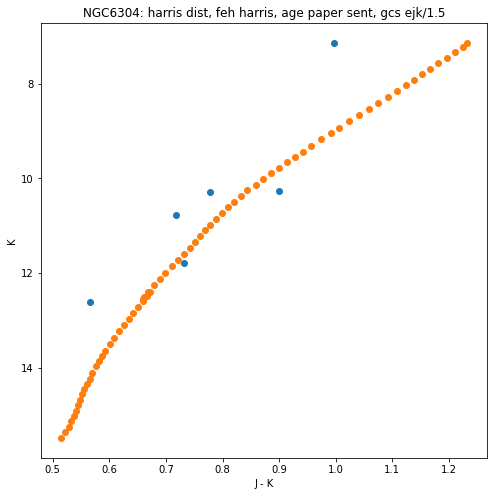

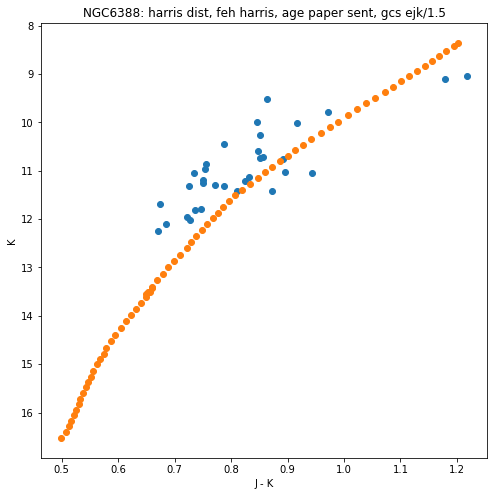

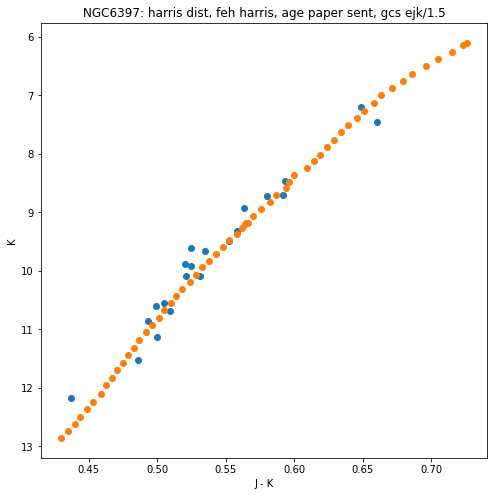

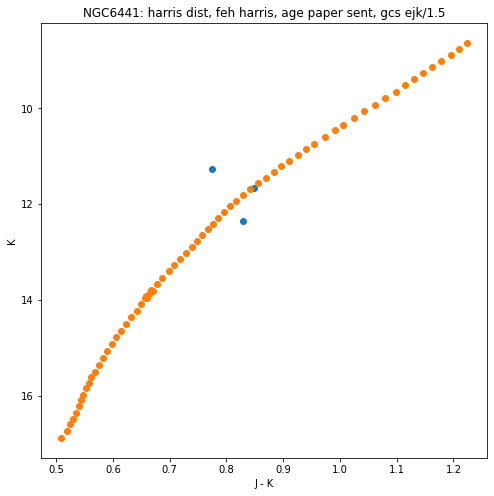

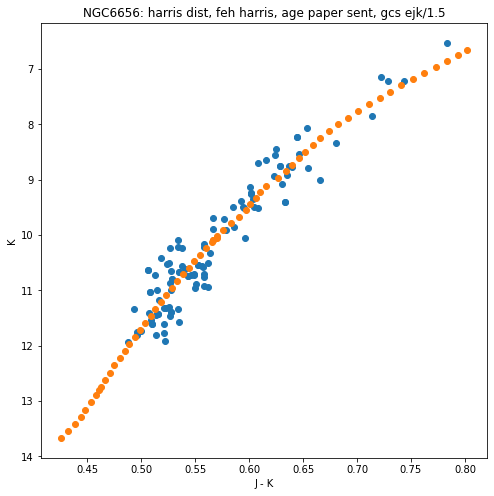

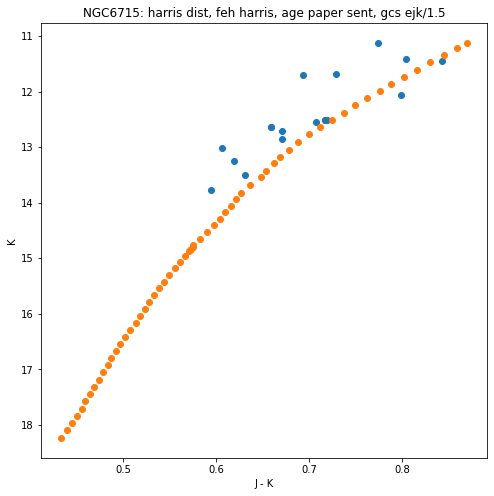

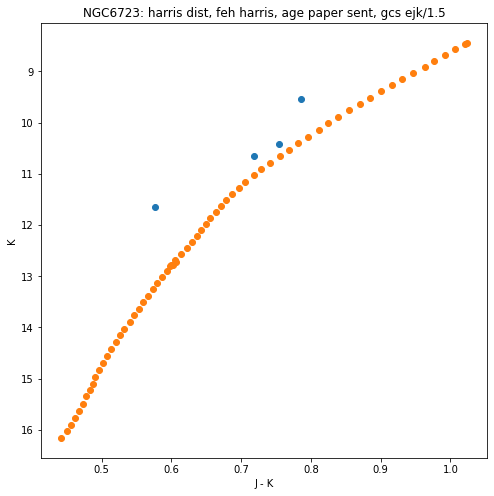

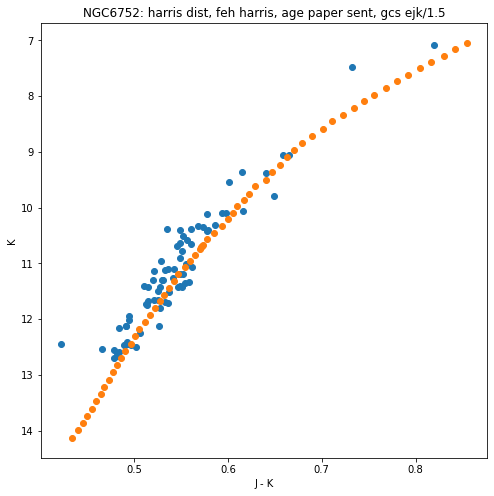

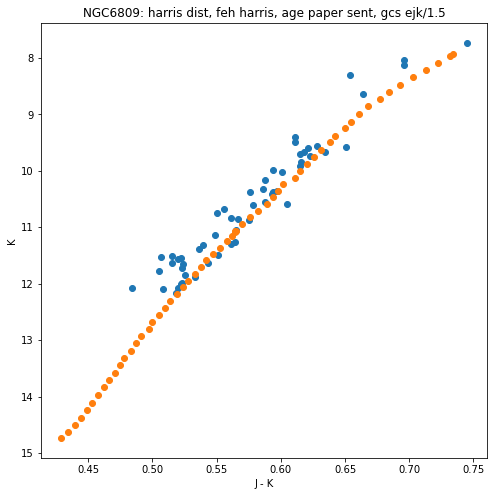

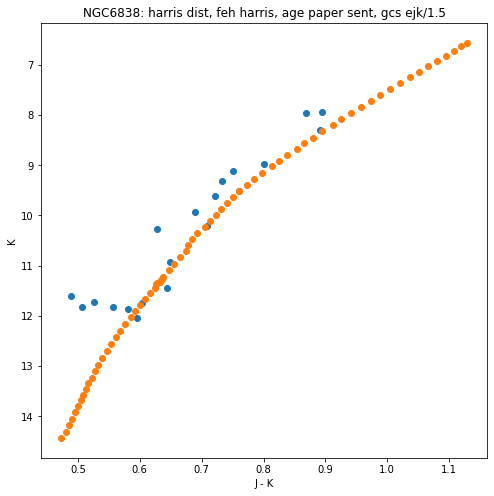

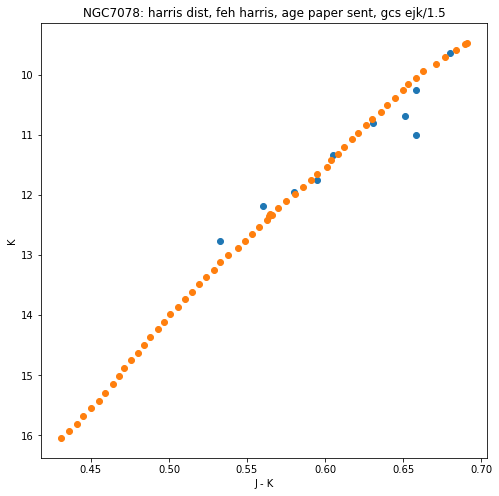

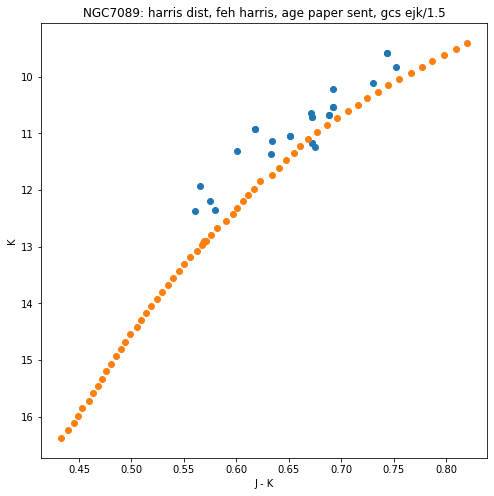

In [10]:
dismod = 5.*np.log10(supp2['harris_dist']*1000)-5.

lits_isos_feh = []
harris_isos_feh = []

for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    clus_feh_med = supp2['[Fe/H]'][i]
    harris_feh = supp2['harris_feh'][i]
    age = np.log10(supp2['Age'][i]*10**9)
    
    lits_isos_feh.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(clus_feh_med,parsec['MH'])))])
    harris_isos_feh.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(harris_feh,parsec['MH'])))])


for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod[i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: harris dist, feh paper sent, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()
    
print('#####################################################################################################')
    
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],harris_isos_feh[i]['Ksmag']+dismod[i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: harris dist, feh harris, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()

In [11]:
gcs.columns

ColDefs(
    name = 'APSTAR_ID'; format = '60A'
    name = 'TARGET_ID'; format = '50A'
    name = 'ASPCAP_ID'; format = '62A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '19A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

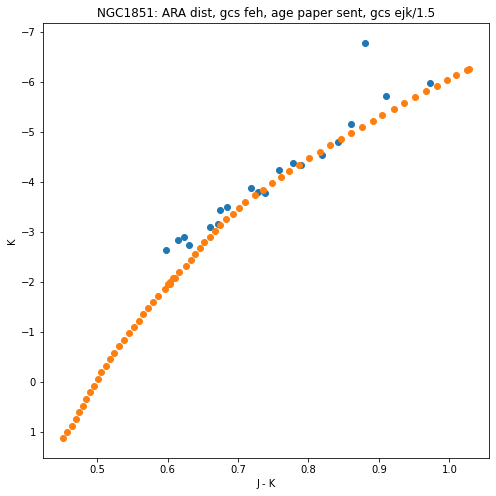

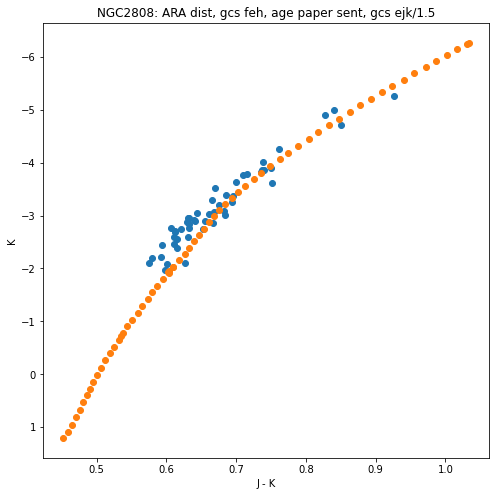

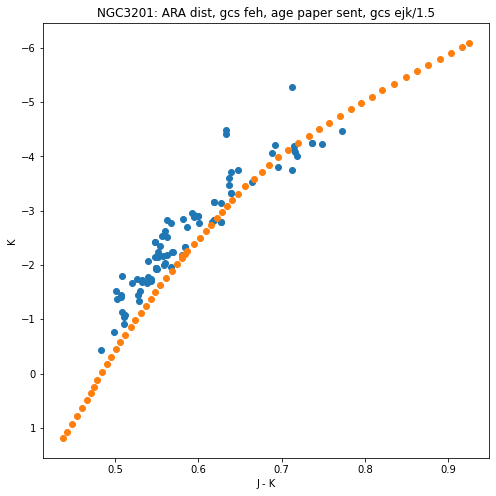

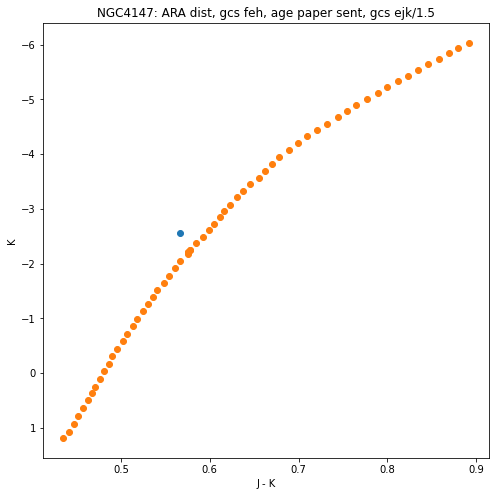

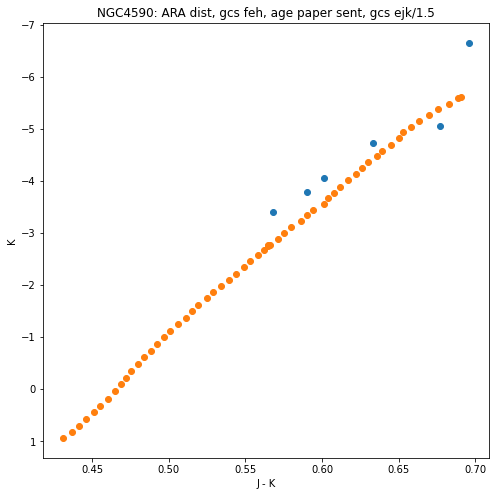

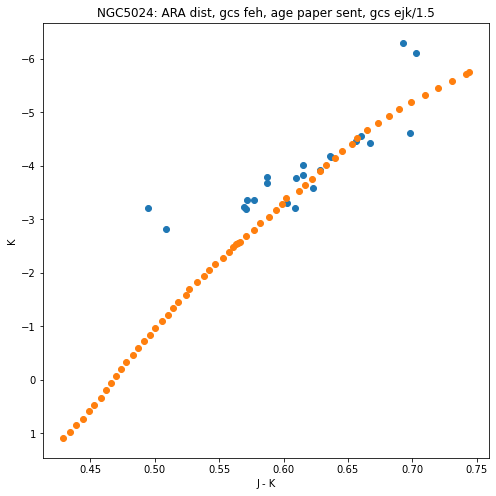

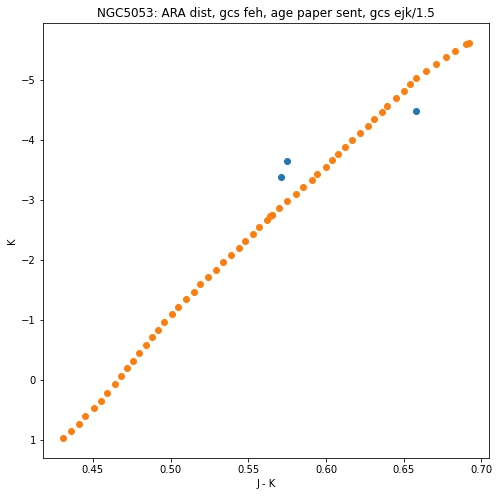

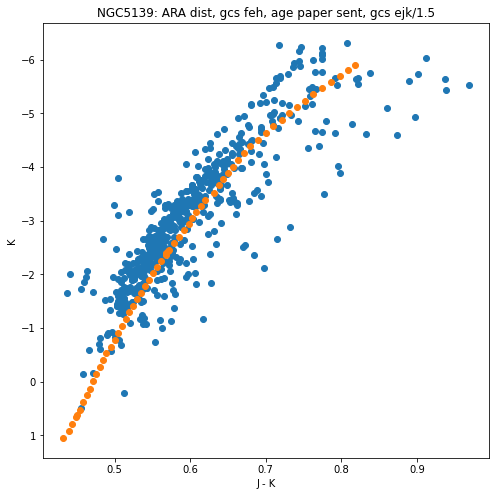

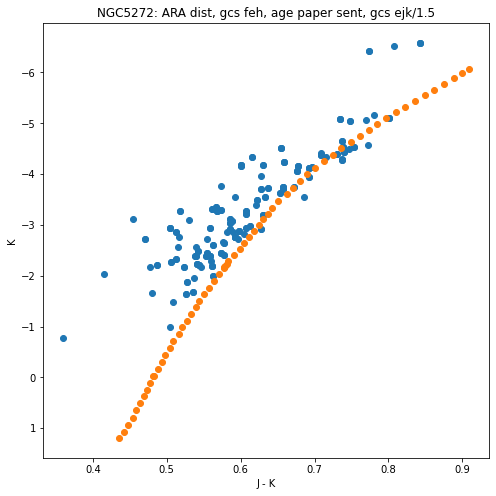

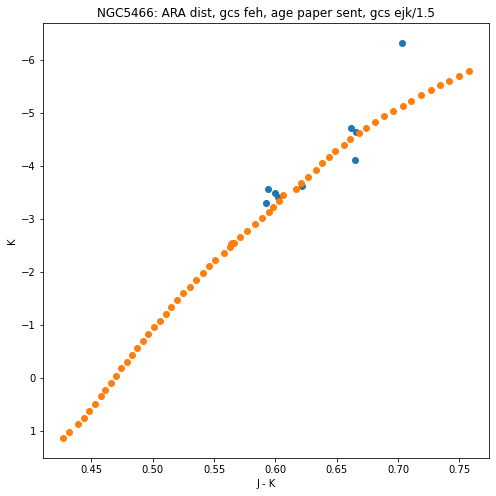

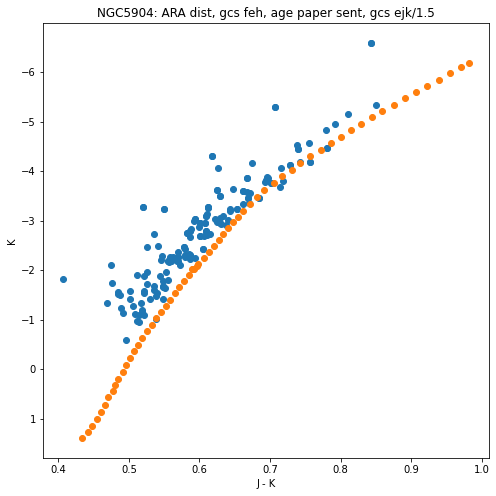

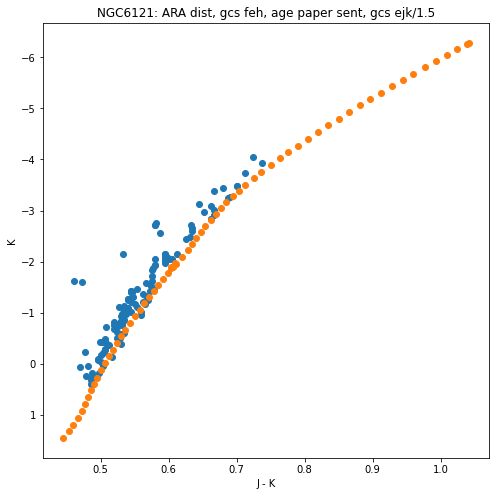

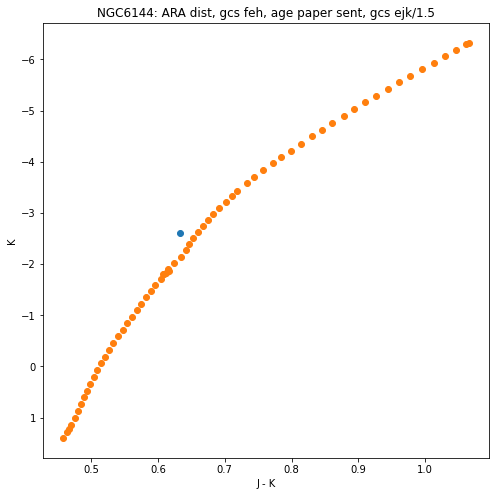

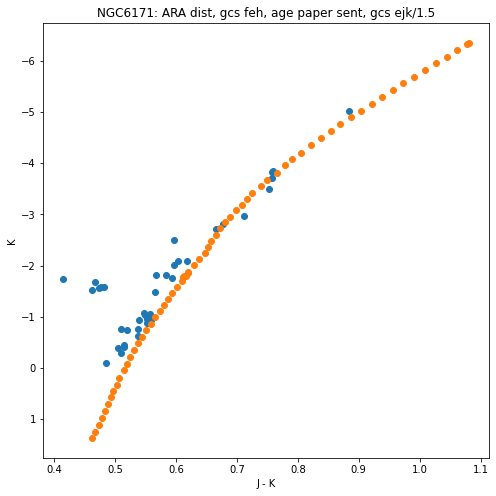

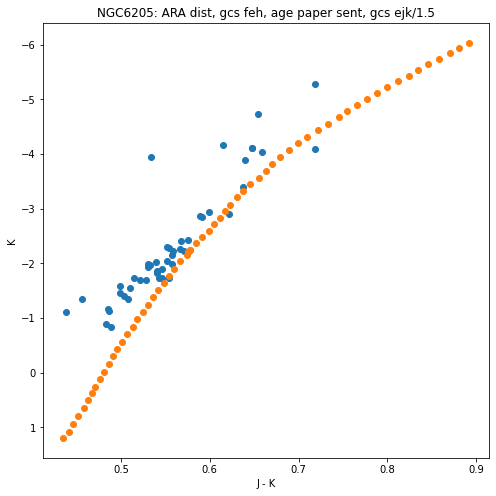

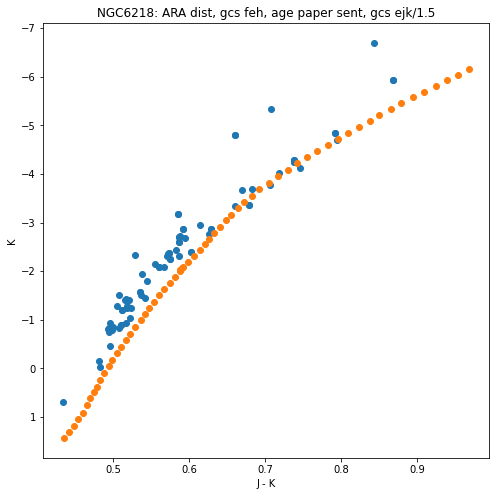

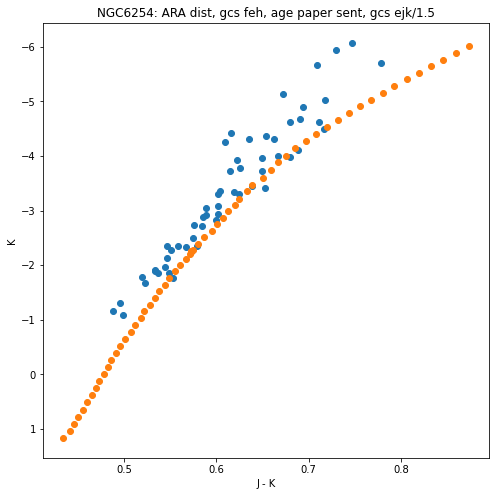

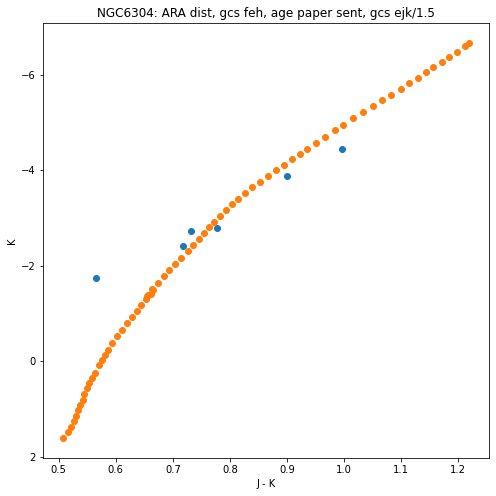

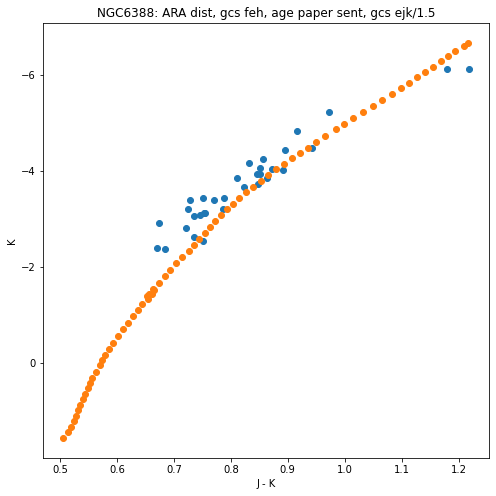

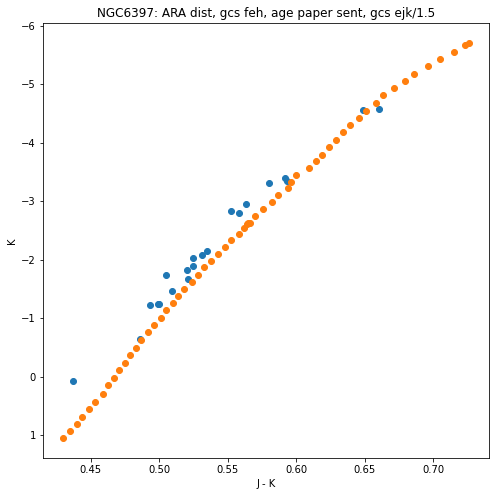

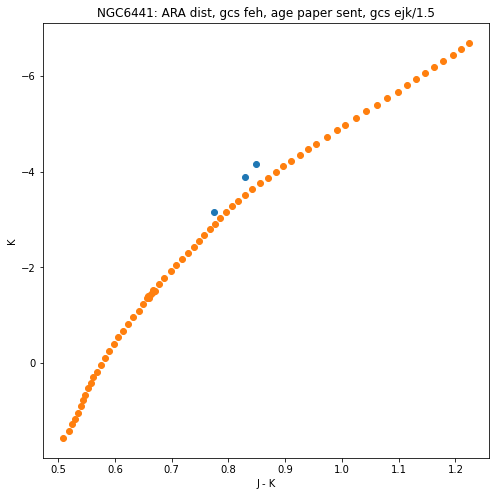

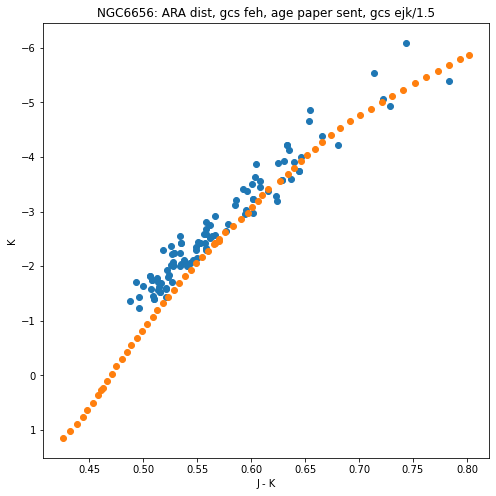

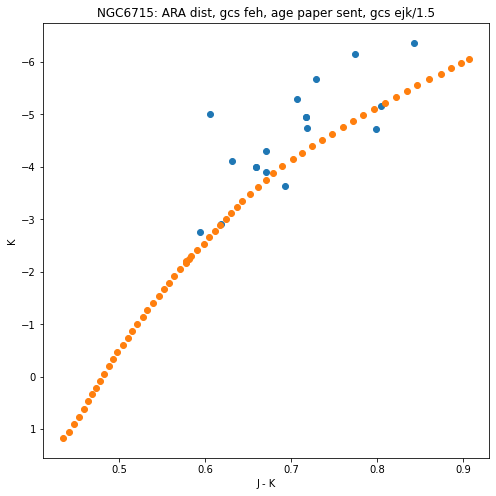

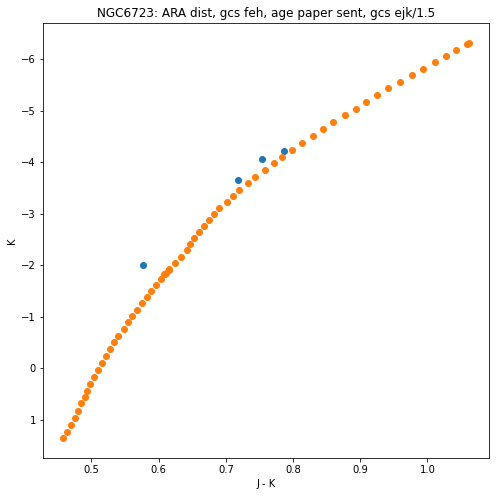

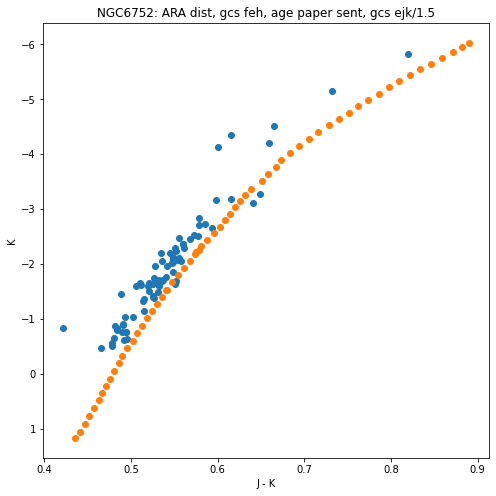

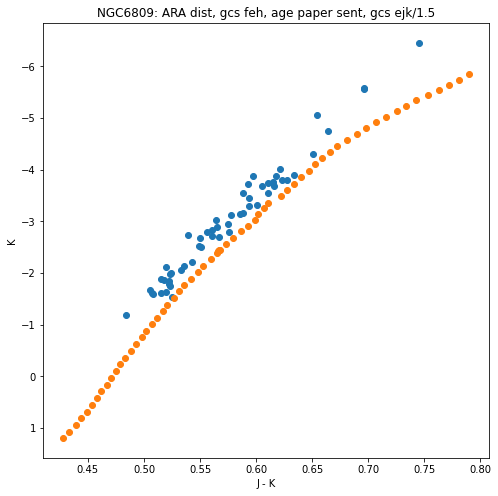

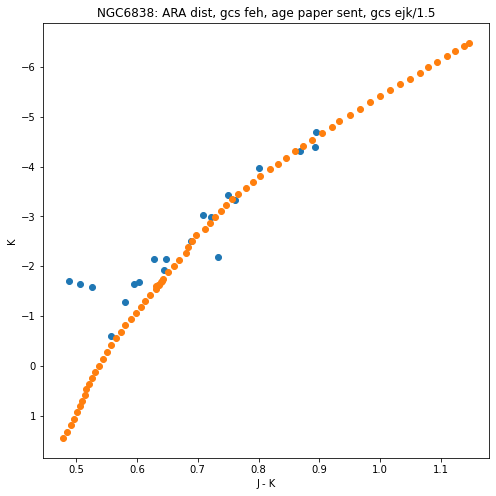

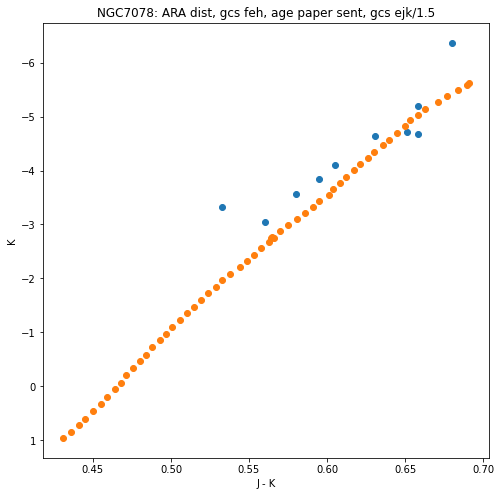

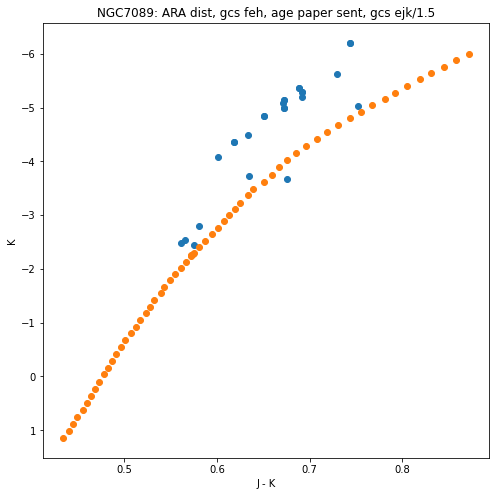

In [12]:
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    dismod = 5.*np.log10(gcs['D1_med'][clus]*1000)-5
    
    plt.figure(figsize=[8,8])
    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dismod*0.99)
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: ARA dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.show()

In [13]:
### ARA Distances

def d2mu(distance):
    '''Convert distance to distance modulus'''
    return 5.*np.log10(distance) - 5.

def mu2d(mu):
    '''convert distance modulus to distance'''
    return 10**((1/5)*(mu+5))


In [122]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.

### Medians and Offsets
first_col = []
first_med_gcs = []
first_med_iso = []
second_col = []
second_med_gcs = []
second_med_iso = []
third_col = []
third_med_gcs = []
third_med_iso = []
fourth_col = []
fourth_med_gcs = []
fourth_med_iso = []
fifth_col = []
fifth_med_gcs = []
fifth_med_iso = []
sixth_col = []
sixth_med_gcs = []
sixth_med_iso = []
seventh_col = []
seventh_med_gcs = []
seventh_med_iso = []
eighth_col = []
eighth_med_gcs = []
eighth_med_iso = []

###
med_g = []
med_f = []

for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    med_g.append(np.median(gcs['logg'][clus]))
    med_f.append(np.median(gcs['FE_H'][clus]))
    
    ### first column
    first_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    first_col.append(first_med)
    first_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]))
    first_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]))
    
    ### second column
    second_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    second_col.append(second_med)
    second_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]))
    second_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975))
    
    
    ### third column
    third_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i])
    third_col.append(third_med)
    third_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]))
    third_med_iso.append(np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i]))
    
    ### fourth column
    fourth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]) - np.median(lits_isos_feh[i]['Ksmag']+dismod1[i])
    fourth_col.append(fourth_med)
    fourth_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]))
    fourth_med_iso.append(np.median(lits_isos_feh[i]['Ksmag']+dismod1[i]))
    
    ### fifth column
    dmod = 5.*np.log10(gcs['distmed'][clus]*1000)-5.
    fifth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-dmod)-np.median(lits_isos[i]['Ksmag'])
    fifth_col.append(fifth_med)
    fifth_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-dmod))
    fifth_med_iso.append(np.median(lits_isos[i]['Ksmag']))
    
    ### sixth column
    ara_mu = -1.2628 + 1.0844*d2mu(gcs['D1_med'][clus]*1000.)
    sixth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-ara_mu)-np.median(lits_isos[i]['Ksmag'])
    sixth_col.append(sixth_med)
    sixth_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-ara_mu))
    sixth_med_iso.append(np.median(lits_isos[i]['Ksmag']))
    
    ### seventh column
    seventh_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(harris_isos_feh[i]['Ksmag']+
                                                                           dismod1[i])
    seventh_col.append(seventh_med)
    seventh_med_gcs.append(np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]))
    seventh_med_iso.append(np.median(harris_isos_feh[i]['Ksmag']+dismod1[i]))
    
    ### eighth column
    eighth_med = np.median((gcs['K']-gcs['AK_TARG'])[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    eighth_col.append(eighth_med)
    eighth_med_gcs.append(np.median((gcs['K']-gcs['AK_TARG'])[clus]))
    eighth_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]))


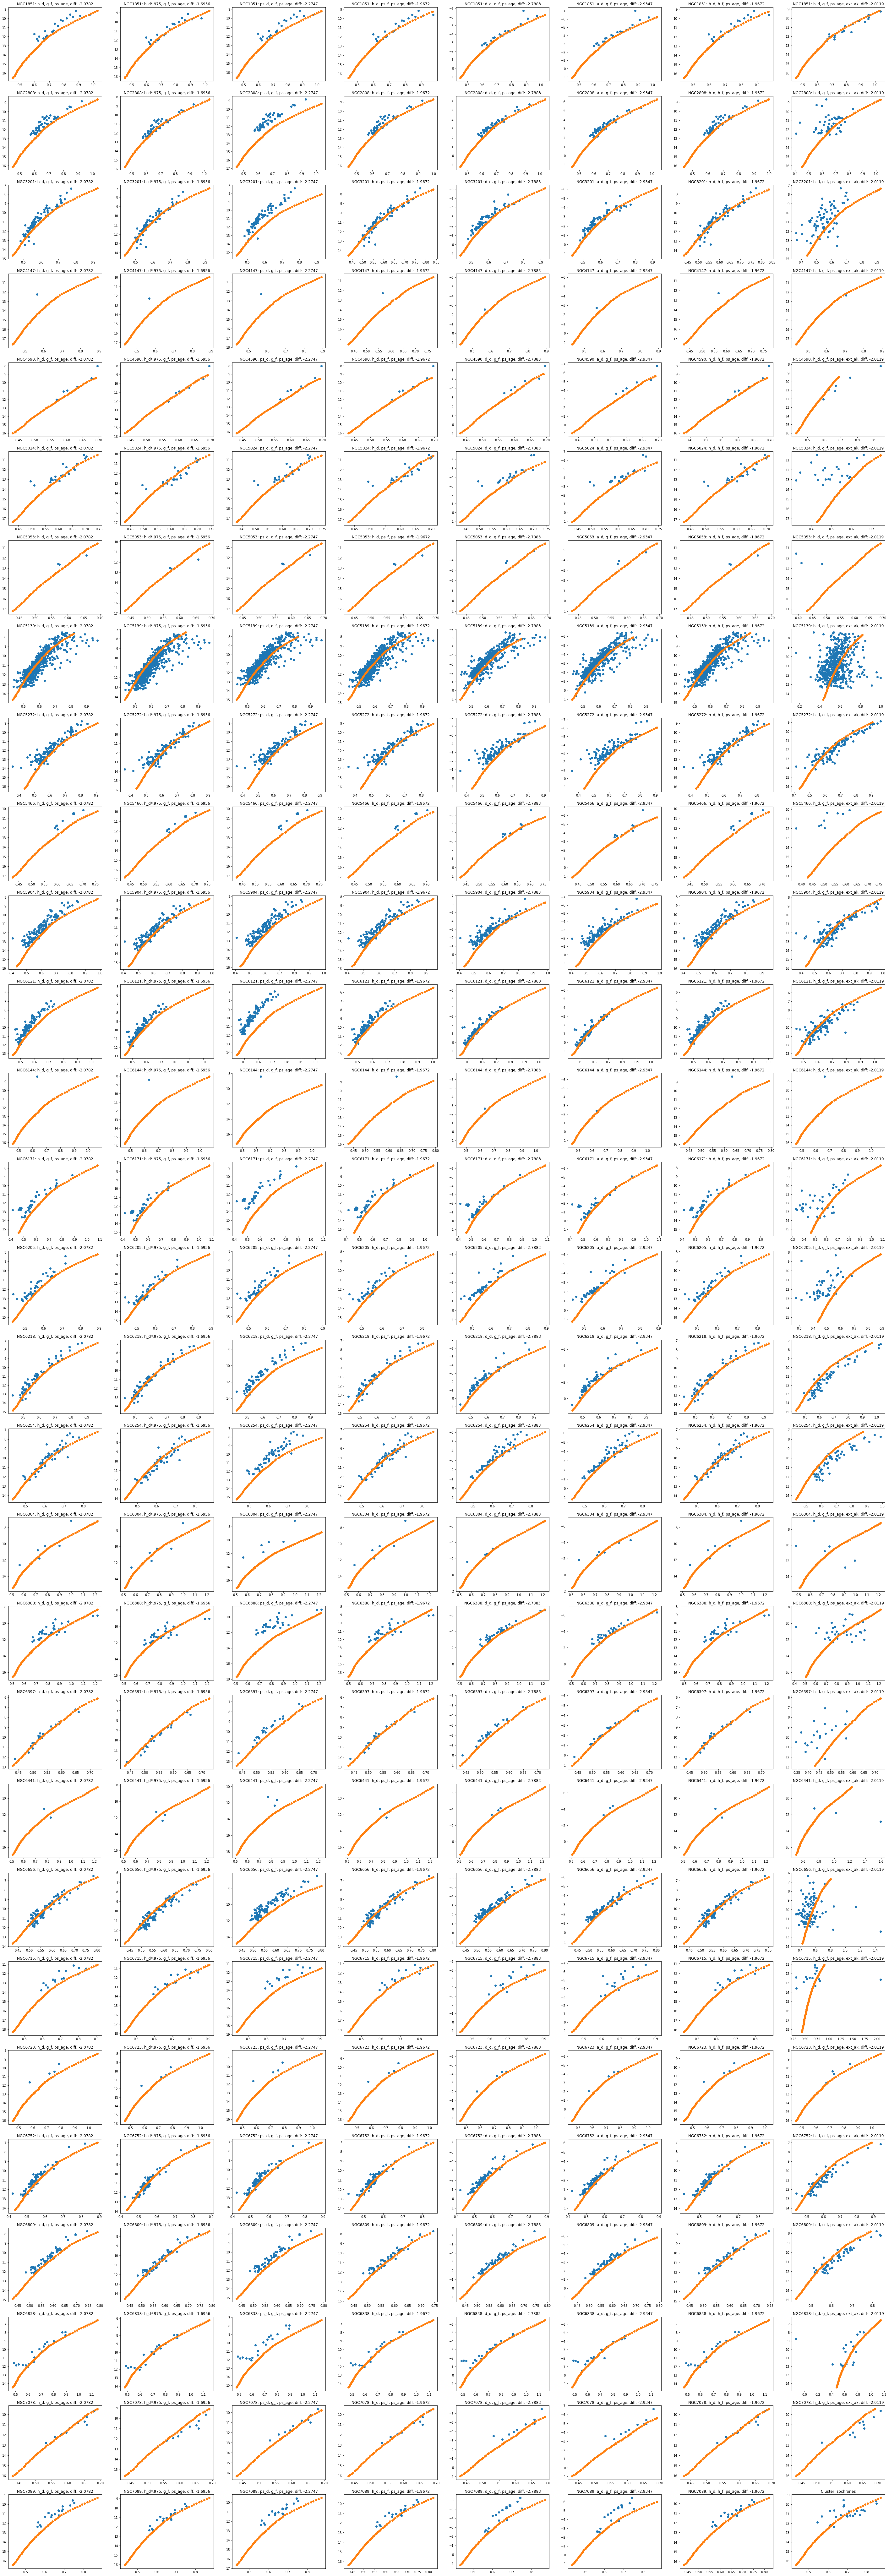

In [92]:
fig,ax=plt.subplots(29,8,figsize=[50,150])
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    ### first column
    ax[i][0].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][0].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
#     first_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
#     first_col.append(first_med)
#     first_med_gcs.append()
    
    ax[i][0].invert_yaxis()
    ax[i][0].set_title(r'{}: h_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],first_med))
    
    ### second column
    ax[i][1].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][1].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.975)
#     second_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975)
#     second_col.append(second_med)
    
    ax[i][1].invert_yaxis()
    ax[i][1].set_title(r'{}: h_d*.975, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],second_med))
    
    ### third column
    ax[i][2].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][2].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
#     third_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i])
#     third_col.append(third_med)
    
    ax[i][2].invert_yaxis()
    ax[i][2].set_title(r'{}: ps_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],third_med))
    
    ### fourth column
    ax[i][3].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][3].scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod1[i])
#     fourth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]) - np.median(lits_isos_feh[i]['Ksmag']+dismod1[i])
#     fourth_col.append(fourth_med)
    
    ax[i][3].invert_yaxis()
    ax[i][3].set_title(r'{}: h_d, ps_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fourth_med))
    
    ### fifth column
    dmod = 5.*np.log10(gcs['distmed'][clus]*1000)-5.
    ax[i][4].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dmod)
    ax[i][4].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
#     fifth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-dmod)-np.median(lits_isos[i]['Ksmag'])
#     fifth_col.append(fifth_med)
    
    ax[i][4].invert_yaxis()
    ax[i][4].set_title(r'{}: d_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fifth_med))
    
    ### sixth column
    ara_mu = -1.2628 + 1.0844*d2mu(gcs['D1_med'][clus]*1000.)
    ax[i][5].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-ara_mu)
    ax[i][5].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
#     sixth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]-ara_mu)-np.median(lits_isos[i]['Ksmag'])
#     sixth_col.append(sixth_med)
    
    ax[i][5].invert_yaxis()
    ax[i][5].set_title(r'{}: a_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],sixth_med))
    
    ### seventh column
    ax[i][6].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][6].scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],
                     harris_isos_feh[i]['Ksmag']+dismod1[i])
#     seventh_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(harris_isos_feh[i]['Ksmag']+dismod1[i])
#     seventh_col.append(seventh_med)
    
    ax[i][6].invert_yaxis()
    ax[i][6].set_title(r'{}: h_d, h_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],seventh_med))
    
    ### eighth column
    ax[i][7].scatter((gcs['J']-gcs['K']-1.5*gcs['AK_TARG'])[clus],(gcs['K']-gcs['AK_TARG'])[clus])
    ax[i][7].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
#     eighth_med = np.median((gcs['K']-gcs['AK_TARG'])[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
#     eighth_col.append(eighth_med)
    
    ax[i][7].invert_yaxis()
    ax[i][7].set_title(r'{}: h_d, g_f, ps_age, ext_ak, diff: {:.4f}'.format(supp2['Cluster'][i],eighth_med))

plt.title(r'Cluster Isochrones')
plt.savefig('clusterisochrones.pdf',bbox_inches='tight',dpi=300)    
plt.show()

# rm APOGEE Derived Distances

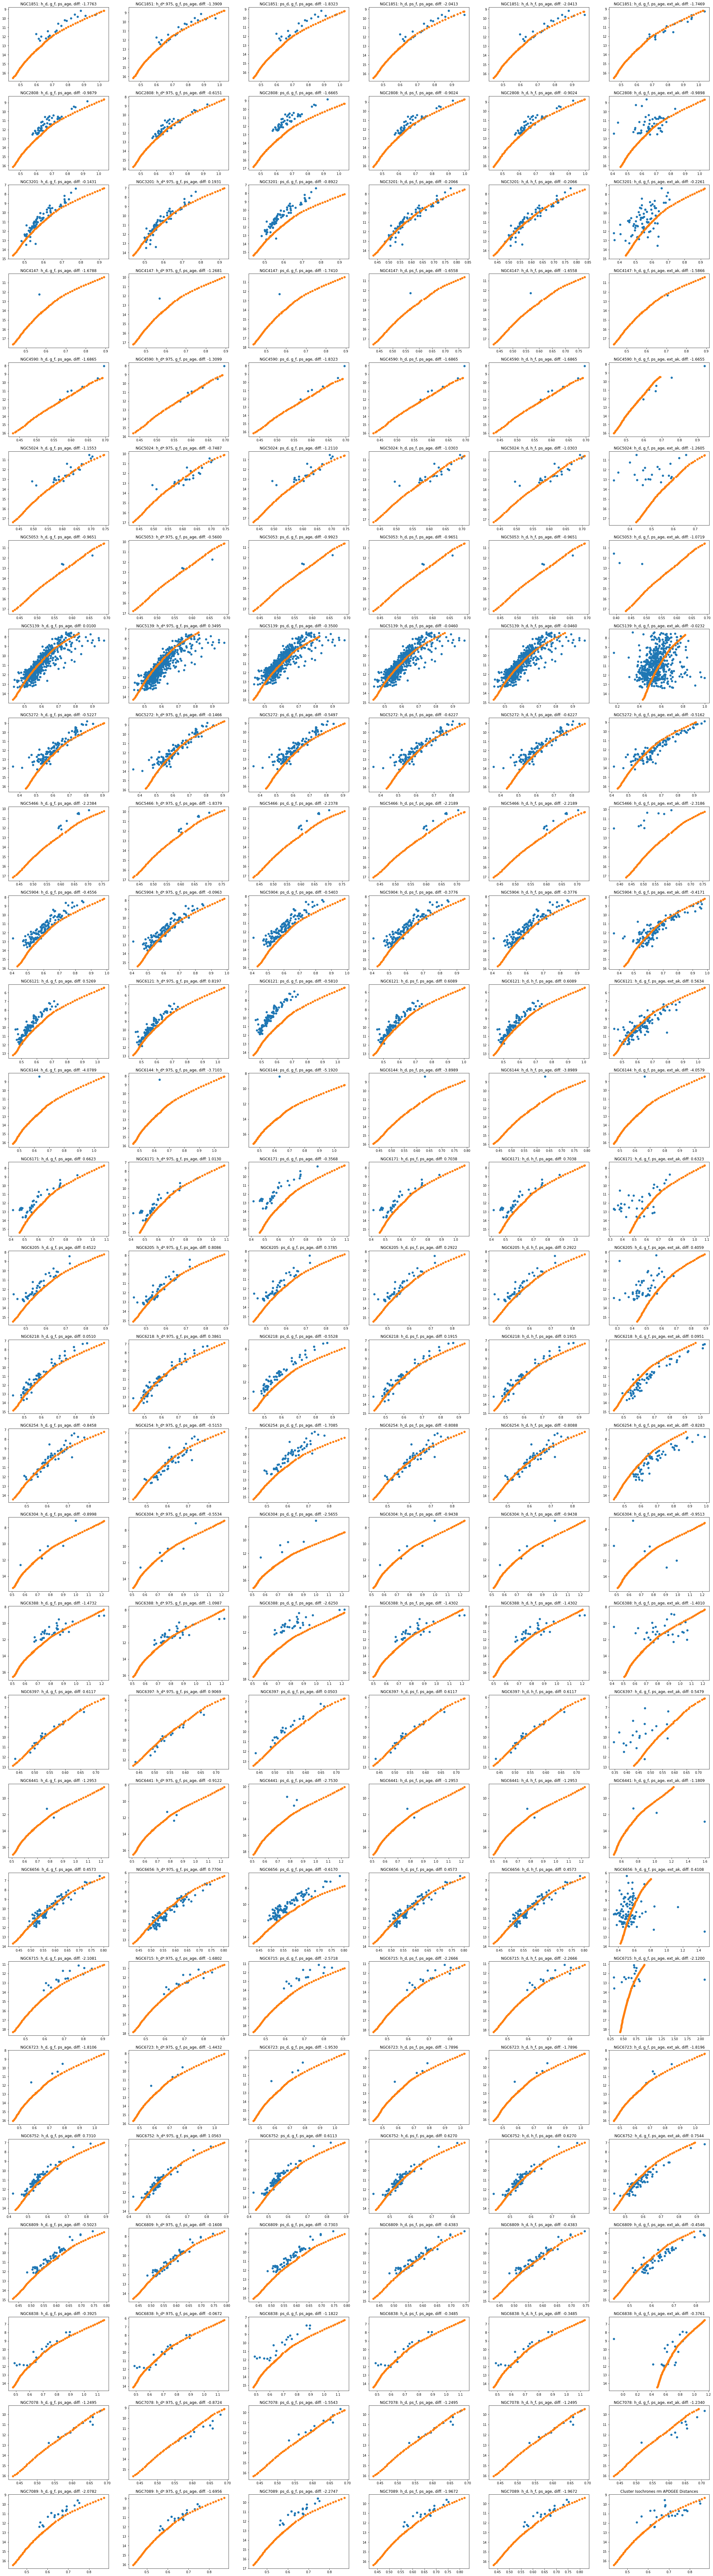

In [126]:
fig,ax=plt.subplots(29,6,figsize=[40,150])
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    ### first column
    ax[i][0].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][0].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    first_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    
    ax[i][0].invert_yaxis()
    ax[i][0].set_title(r'{}: h_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],first_med))
    
    ### second column
    ax[i][1].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][1].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    second_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    
    ax[i][1].invert_yaxis()
    ax[i][1].set_title(r'{}: h_d*.975, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],second_med))
    
    ### third column
    ax[i][2].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][2].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
    third_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i])
    
    ax[i][2].invert_yaxis()
    ax[i][2].set_title(r'{}: ps_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],third_med))
    
    ### fourth column
    ax[i][3].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][3].scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod1[i])
    fourth_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus]) - np.median(lits_isos_feh[i]['Ksmag']+dismod1[i])
    
    ax[i][3].invert_yaxis()
    ax[i][3].set_title(r'{}: h_d, ps_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fourth_med))

    
    ### seventh column
    ax[i][4].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    ax[i][4].scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],
                     harris_isos_feh[i]['Ksmag']+dismod1[i])
    seventh_med = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(harris_isos_feh[i]['Ksmag']+dismod1[i])
    
    ax[i][4].invert_yaxis()
    ax[i][4].set_title(r'{}: h_d, h_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],seventh_med))
    
    ### eighth column
    ax[i][5].scatter((gcs['J']-gcs['K']-1.5*gcs['AK_TARG'])[clus],(gcs['K']-gcs['AK_TARG'])[clus])
    ax[i][5].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    eighth_med = np.median((gcs['K']-gcs['AK_TARG'])[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    
    ax[i][5].invert_yaxis()
    ax[i][5].set_title(r'{}: h_d, g_f, ps_age, ext_ak, diff: {:.4f}'.format(supp2['Cluster'][i],eighth_med))
    
plt.title(r'Cluster Isochrones rm APOGEE Distances')
plt.savefig('clusterisochrones_rmapogee.pdf',bbox_inches='tight',dpi=300)    
plt.show()

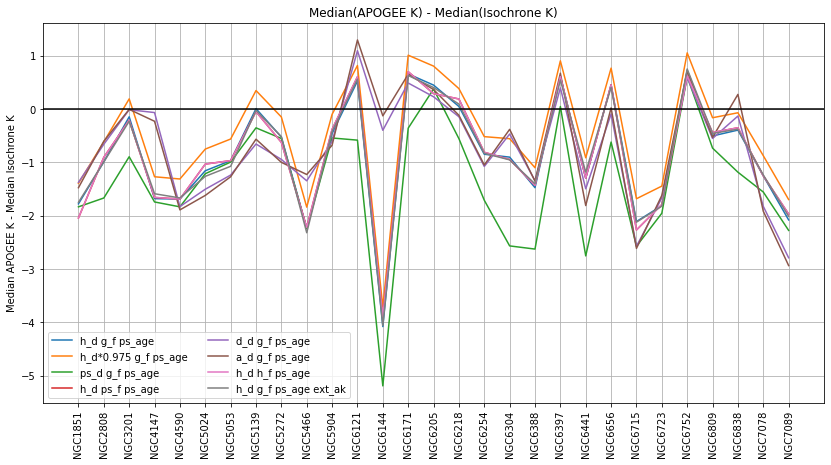

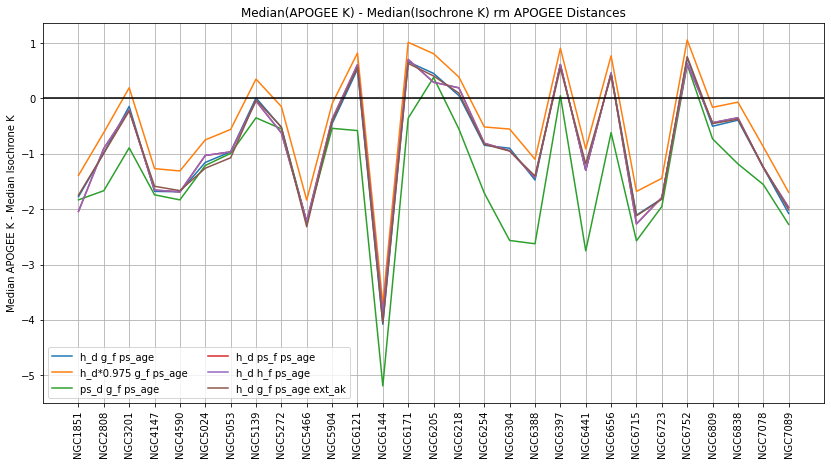

In [83]:
difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.plot(col_meds[i],label=difflabs[i])
plt.axhline(0,c='k')

plt.legend(ncol=2)

plt.xticks(np.arange(0.,29.,1.),supp2['Cluster'],rotation=90)
plt.grid()

plt.ylabel('Median APOGEE K - Median Isochrone K')
plt.title(r'Median(APOGEE K) - Median(Isochrone K)')
plt.savefig('mediandiffK.pdf',bbox_inches='tight',dpi=300)
plt.show()

########################

difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","h_d h_f ps_age",
            "h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.plot(col_meds[i],label=difflabs[i])
plt.axhline(0,c='k')

plt.legend(ncol=2)

plt.xticks(np.arange(0.,29.,1.),supp2['Cluster'],rotation=90)
plt.grid()

plt.ylabel('Median APOGEE K - Median Isochrone K')
plt.title(r'Median(APOGEE K) - Median(Isochrone K) rm APOGEE Distances')
plt.savefig('mediandiffK_rmapogee.pdf',bbox_inches='tight',dpi=300)
plt.show()

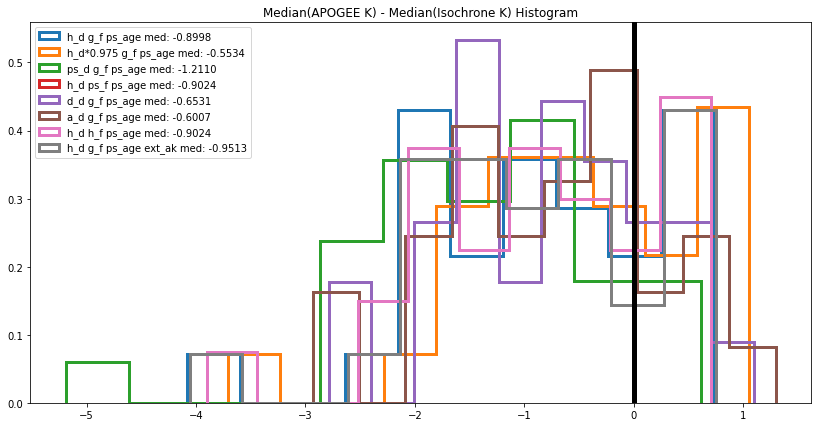

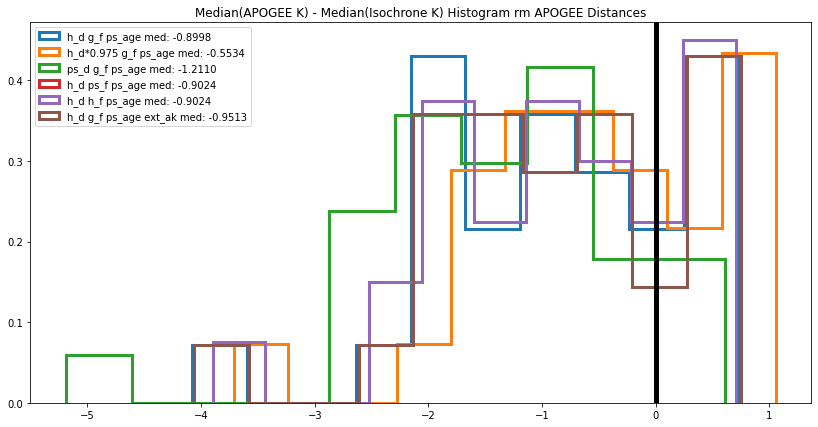

In [84]:
difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.hist(col_meds[i],label=difflabs[i]+' med: {:.4f}'.format(np.median(col_meds[i])),density=True,lw=3.0,
             histtype='step')
plt.axvline(0,c='k',lw=5.0)

plt.legend(loc='upper left')

plt.title(r'Median(APOGEE K) - Median(Isochrone K) Histogram')
plt.savefig('mediandiffK_hist.pdf',bbox_inches='tight',dpi=300)
plt.show()

#######

difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","h_d h_f ps_age",
            "h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.hist(col_meds[i],label=difflabs[i]+' med: {:.4f}'.format(np.median(col_meds[i])),density=True,lw=3.0,
             histtype='step')
plt.axvline(0,c='k',lw=5.0)
plt.legend(loc='upper left')

plt.title(r'Median(APOGEE K) - Median(Isochrone K) Histogram rm APOGEE Distances')
plt.savefig('mediandiffK_hist_rmapogee.pdf',bbox_inches='tight',dpi=300)
plt.show()

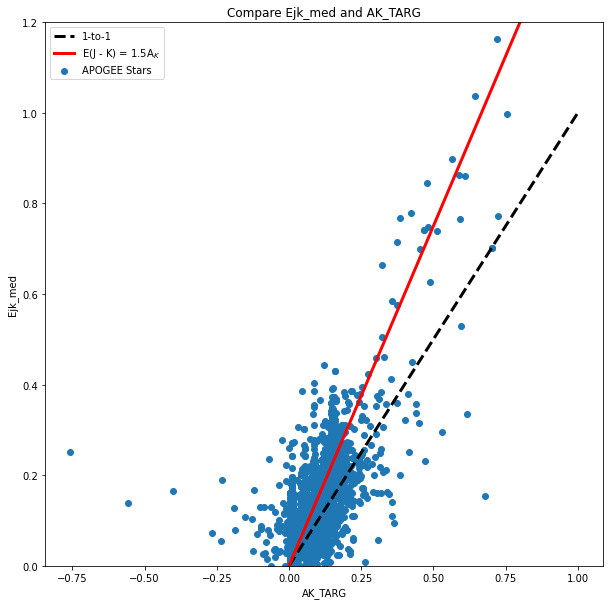

In [85]:
z = np.polyfit(gcs['AK_TARG'], gcs['Ejk_med'], 1)
p = np.poly1d(z)

plt.figure(figsize=[10,10])
plt.scatter(gcs['AK_TARG'],gcs['Ejk_med'],label='APOGEE Stars')
plt.plot([0,1],[0,1],c='k',ls='--',lw=3.0,label='1-to-1')
plt.plot([0,1],[0,1.5],c='r',lw=3.0,label=r'E(J - K) = 1.5A$_K$')
# plt.plot([-0.5,1],[p(-0.5),p(1)],lw=3.0,c='darkorange',label='Polyfit')

plt.legend()

plt.ylim(0,1.2)

plt.xlabel(r'AK_TARG')
plt.ylabel(r'Ejk_med')

plt.title(r'Compare Ejk_med and AK_TARG')
plt.savefig('ak_ext_compare.pdf',bbox_inches='tight',dpi=300)
plt.show()

# median offsets

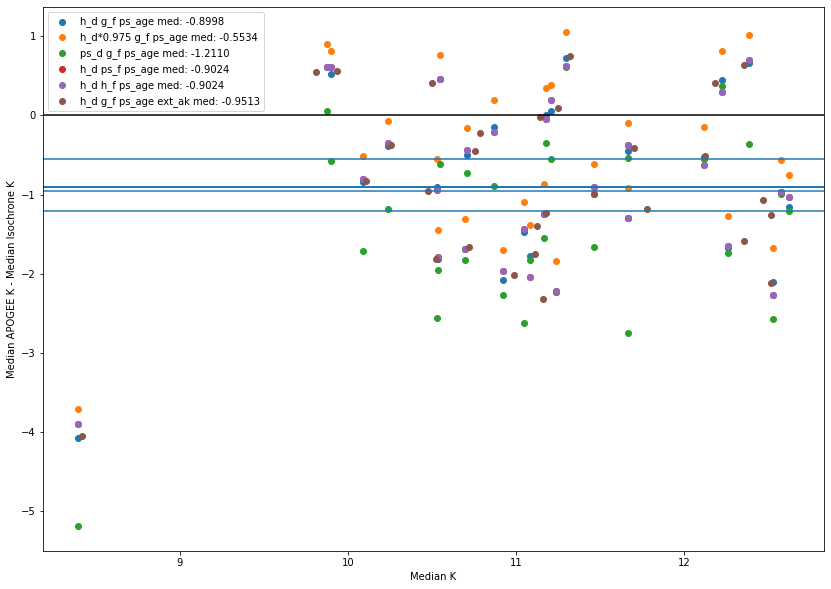

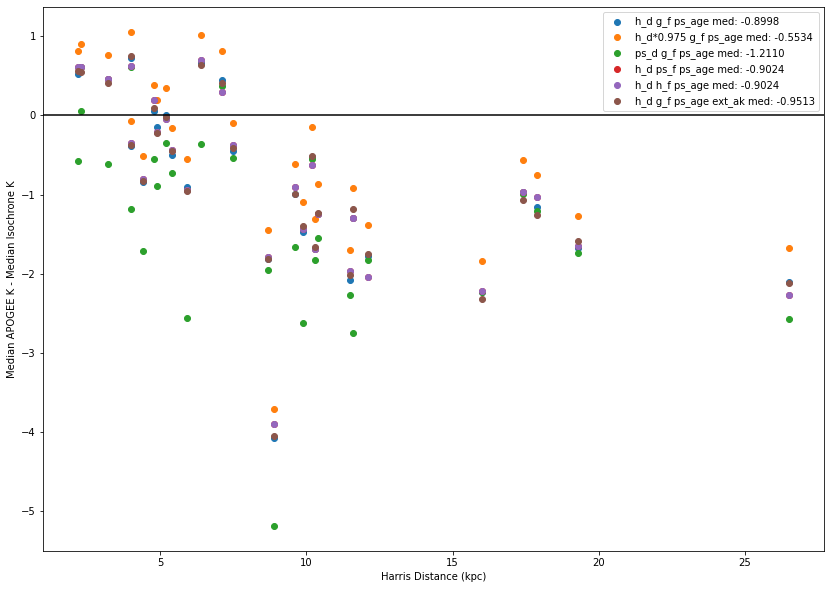

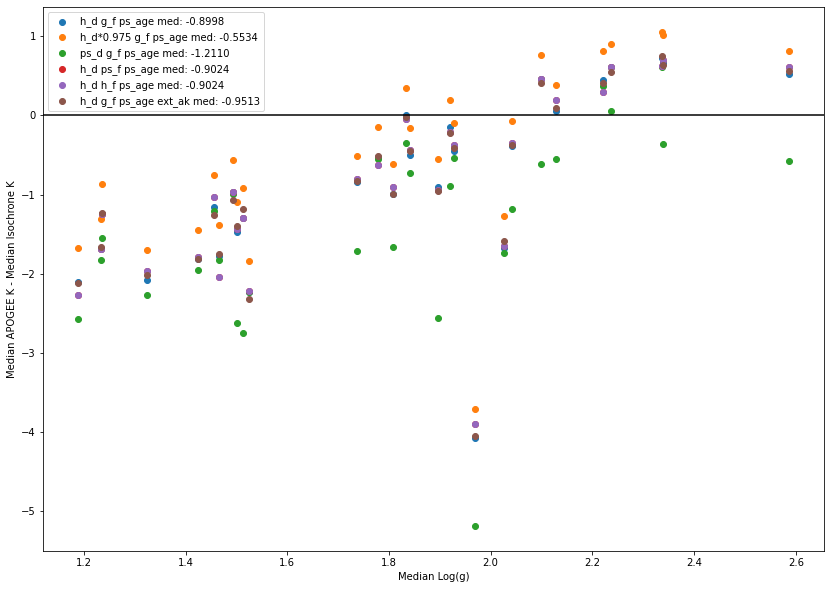

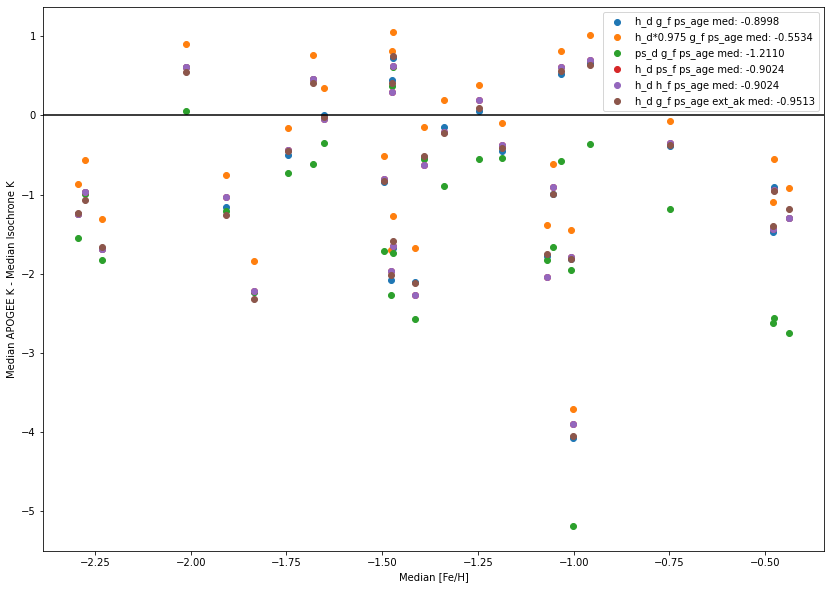

In [234]:
lab_cols = np.array(["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"])
offset_cols = np.array([first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col])
meds_cols = np.array([first_med_gcs,second_med_gcs,third_med_gcs,fourth_med_gcs,fifth_med_gcs,sixth_med_gcs,
                      seventh_med_gcs,eighth_med_gcs])

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    plt.scatter(meds_cols[i],offset_cols[i],label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.axhline(np.median(offset_cols[i]))
    
plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

#########

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(supp2['harris_dist'],offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Harris Distance (kpc)')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()


#########

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(med_g,offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median Log(g)')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

############

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(med_f,offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median [Fe/H]')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()


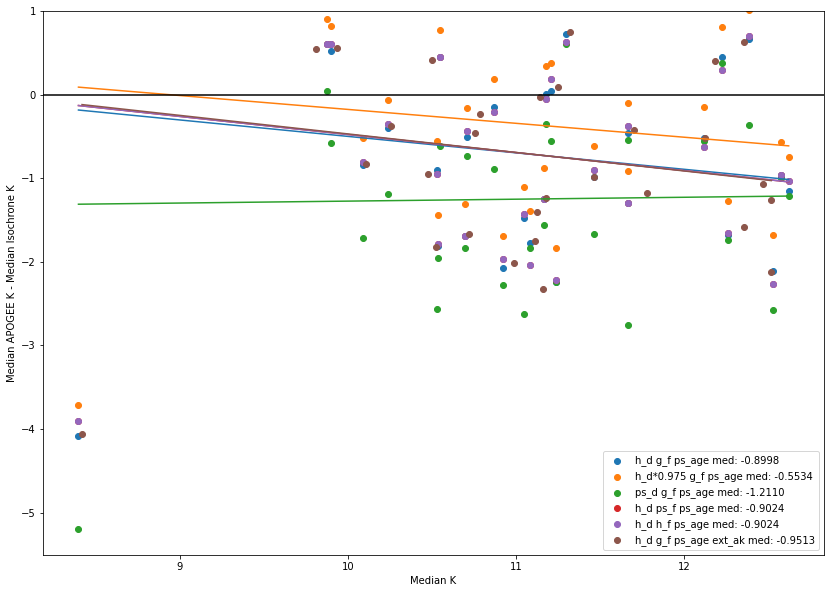

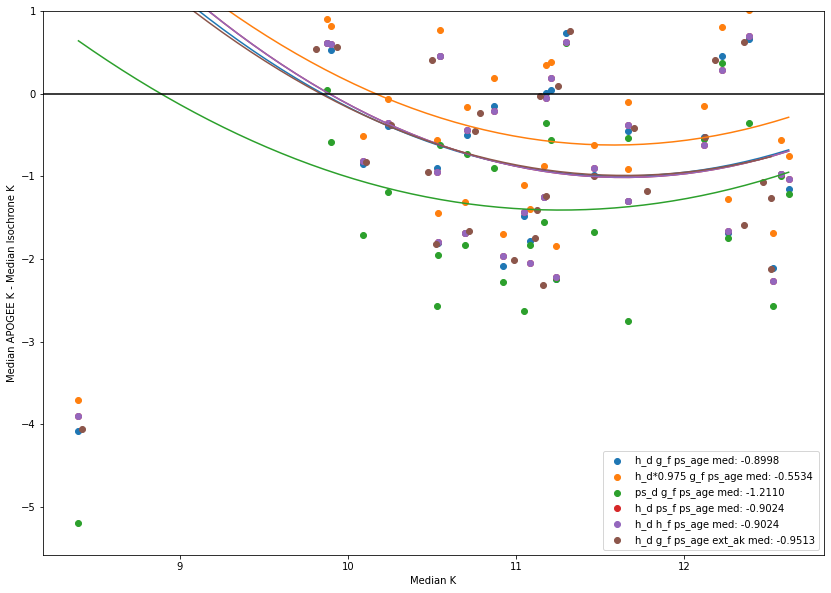

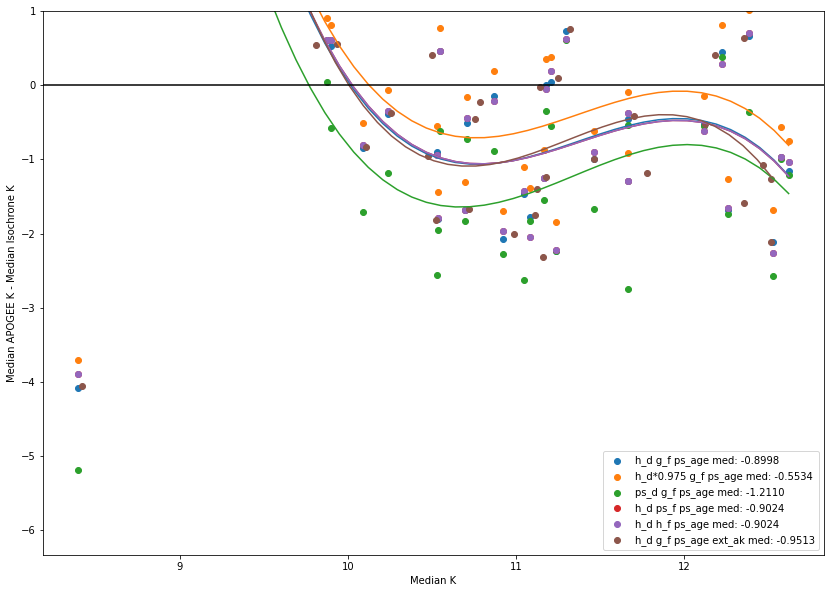

In [224]:
goo_clus = np.where(supp2['Cluster']!='NGC6144')

linParams = []
quaParams = []
cubParams = []

for i in [0,1,2,3,4,5,6,7]:
    linParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],1))
    quaParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],2))
    cubParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],3))

poly_labels = np.array(["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age",
                        "d_d g_f ps_age","a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"])

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(linParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

###

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(quaParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

###

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(cubParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

# Explore Harris Distance Scaling

In [243]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.
fact = np.arange(0.85,1.0,0.01)
    
all_diff_shifts = []
all_diff_shifts_med = [] 
for i in range(len(fact)):
    clus_med_k = []
    for j in range(len(supp2)):
        meds = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[j]['Ksmag']+dismod1[j]*fact[i])
        clus_med_k.append(meds)
    all_diff_shifts.append(clus_med_k)
    all_diff_shifts_med.append(np.median(clus_med_k))

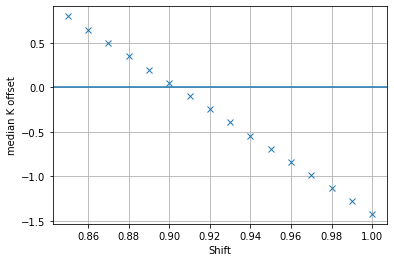

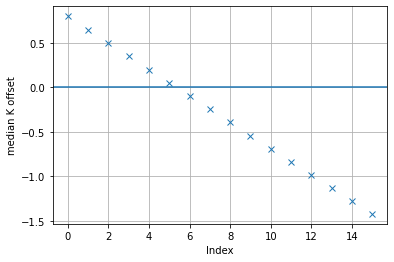

0.9


In [257]:
plt.plot(fact,all_diff_shifts_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Shift')
plt.show()

plt.plot(all_diff_shifts_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Index')
plt.show()


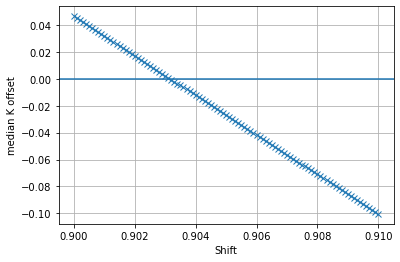

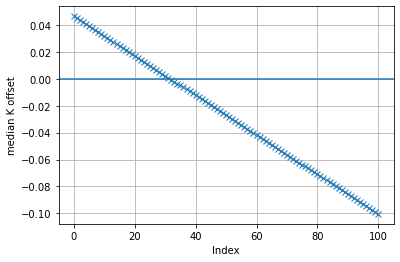

In [261]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.
fact_fin = np.arange(0.90,0.91,0.0001)
    
all_diff_shifts_fin = []
all_diff_shifts_fin_med = [] 
for i in range(len(fact_fin)):
    clus_med_k = []
    for j in range(len(supp2)):
        meds = (np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-
                np.median(lits_isos[j]['Ksmag']+dismod1[j]*fact_fin[i]))
        clus_med_k.append(meds)
    all_diff_shifts_fin.append(clus_med_k)
    all_diff_shifts_fin_med.append(np.median(clus_med_k))
    
plt.plot(fact_fin,all_diff_shifts_fin_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Shift')
plt.show()

plt.plot(all_diff_shifts_fin_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Index')
plt.show()

In [270]:
# Scale Closest to zero offset in median K
fact_fin[np.where(all_diff_shifts_fin_med==-min(np.abs(all_diff_shifts_fin_med)))]

array([0.9032])

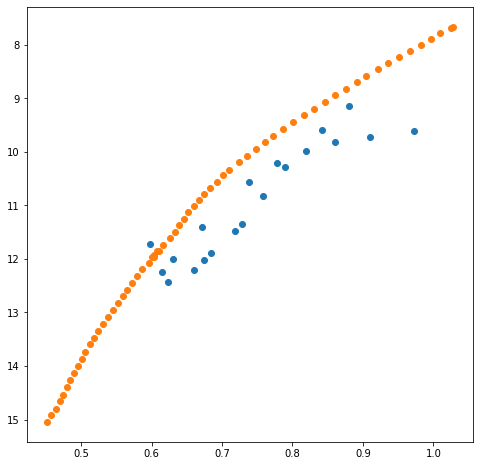

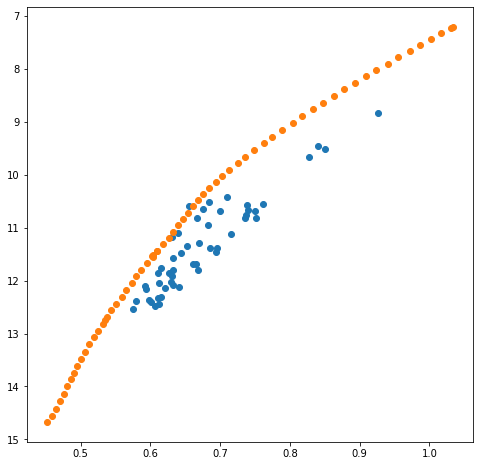

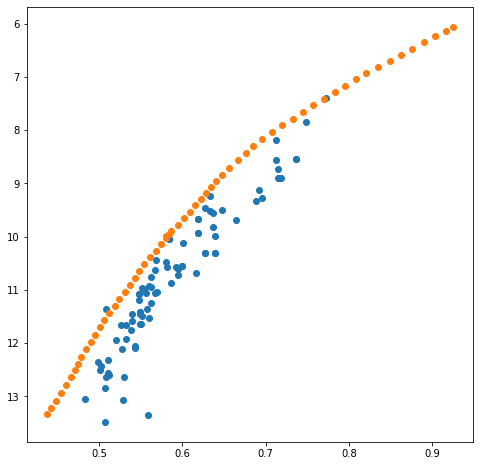

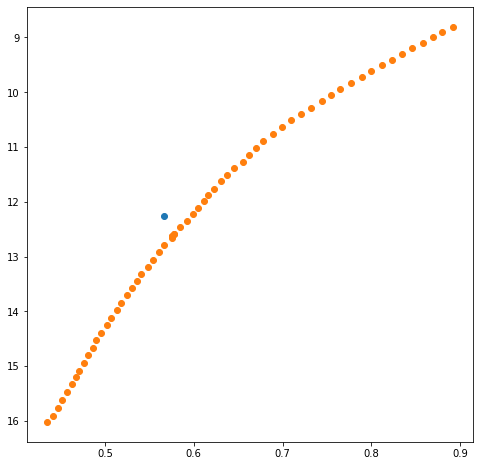

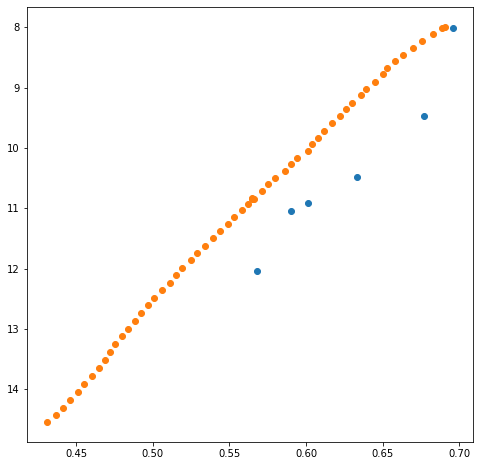

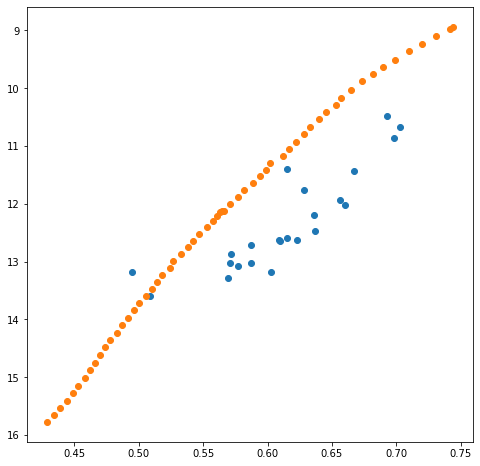

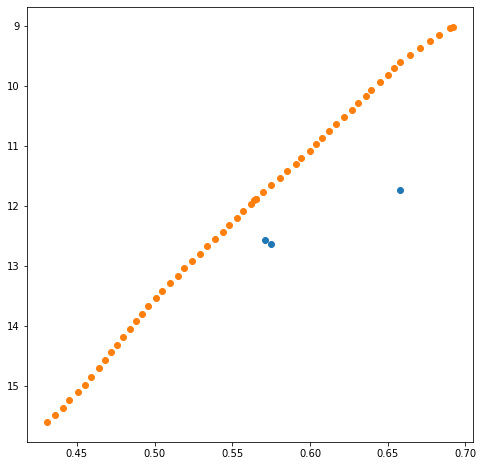

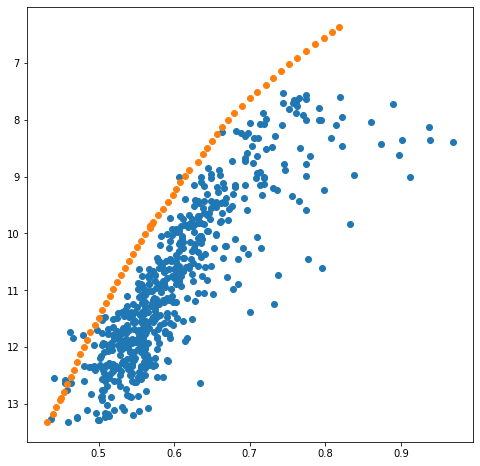

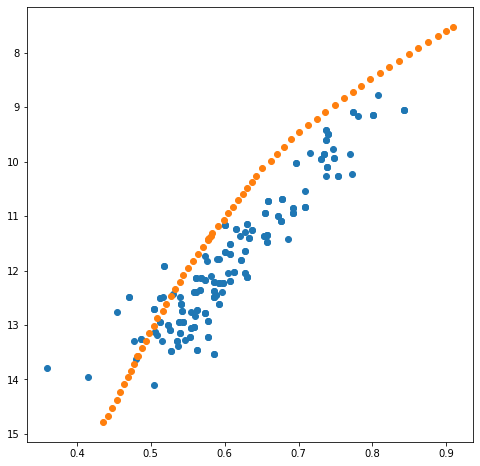

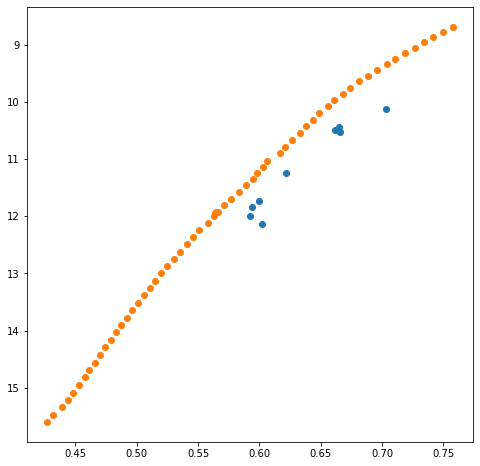

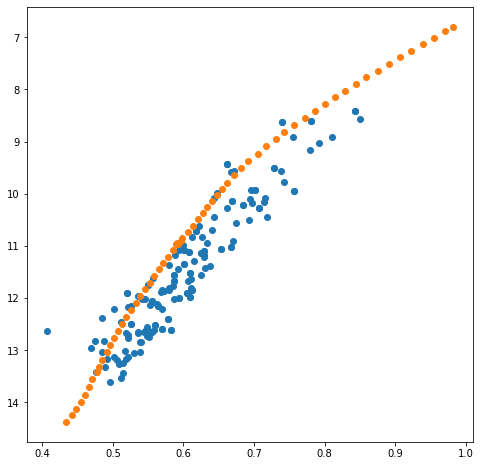

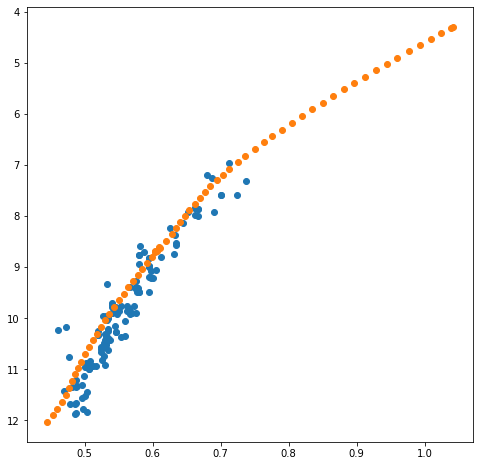

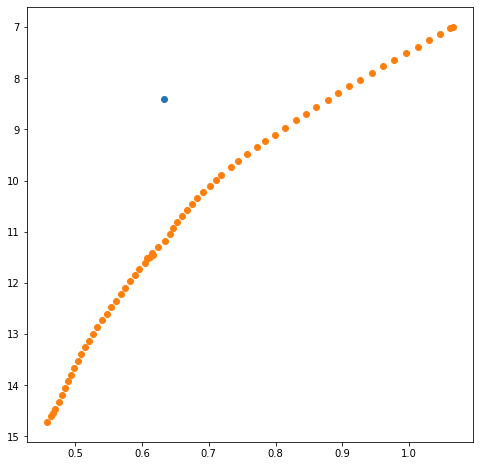

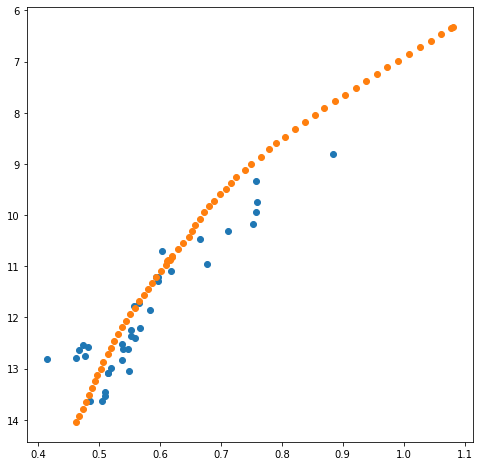

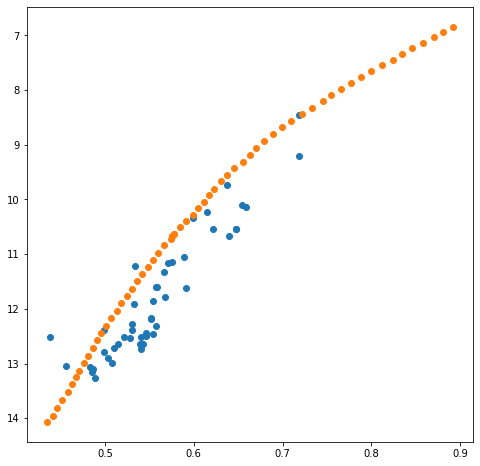

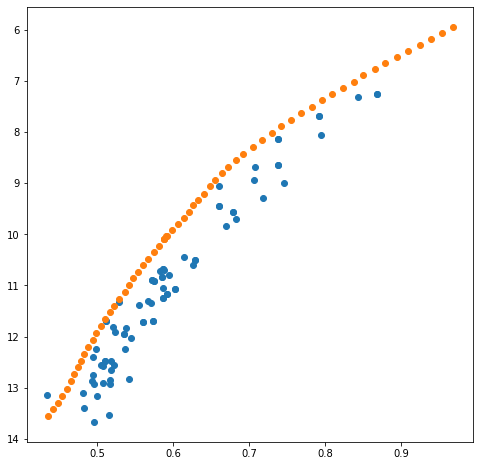

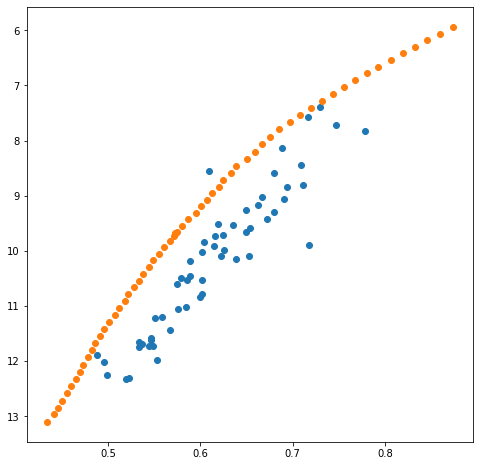

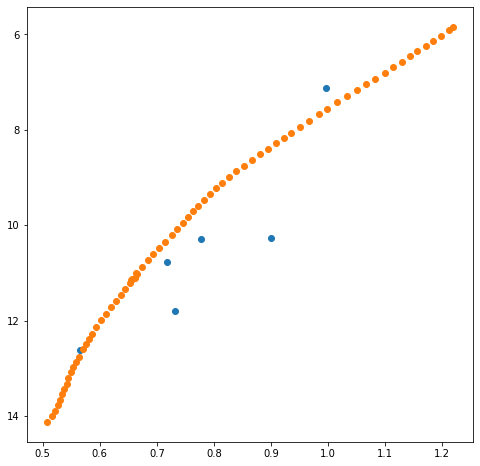

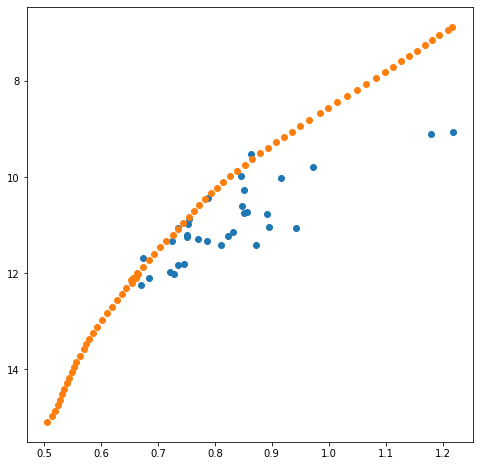

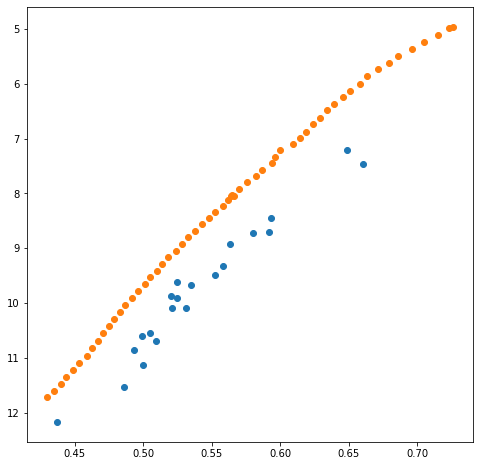

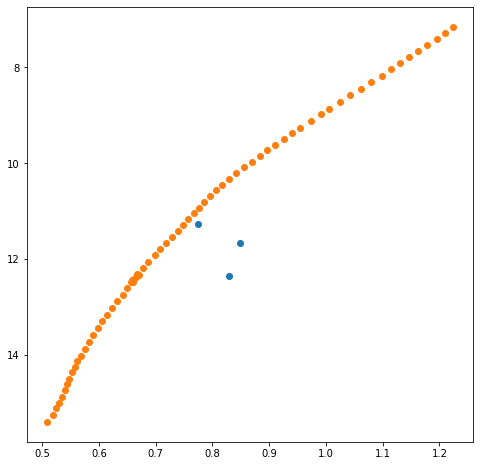

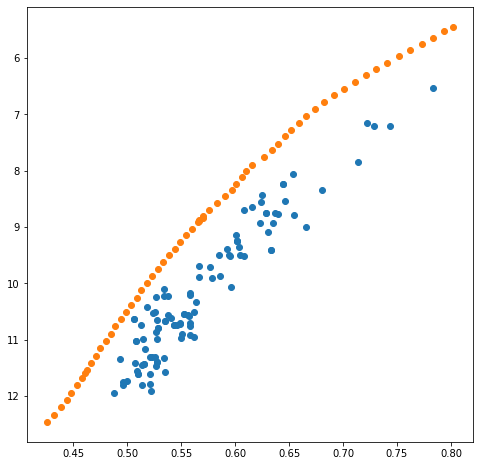

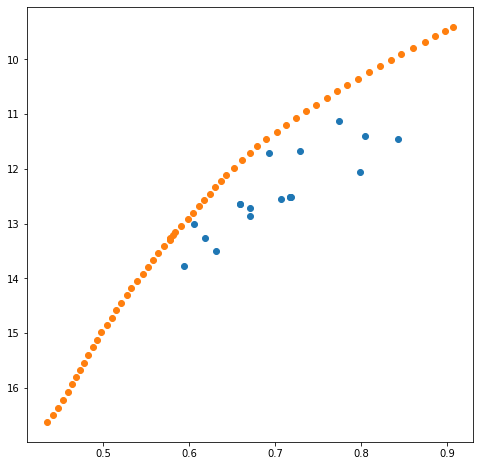

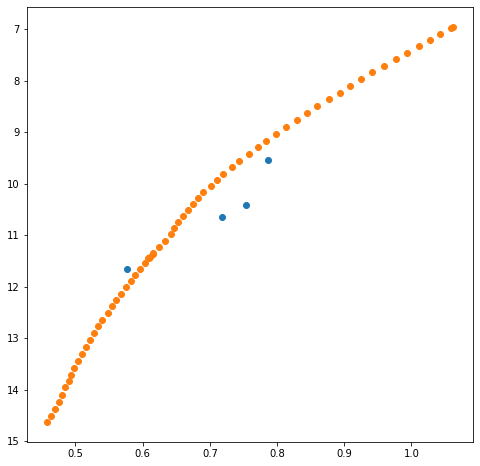

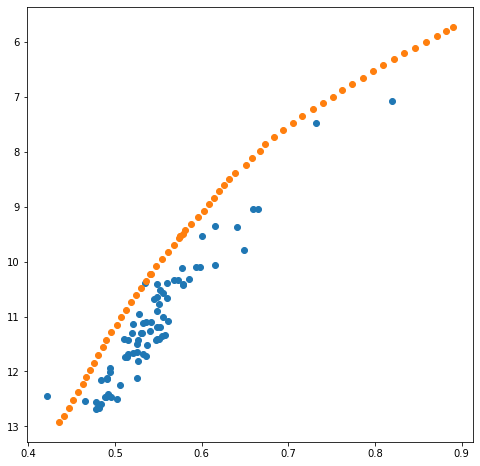

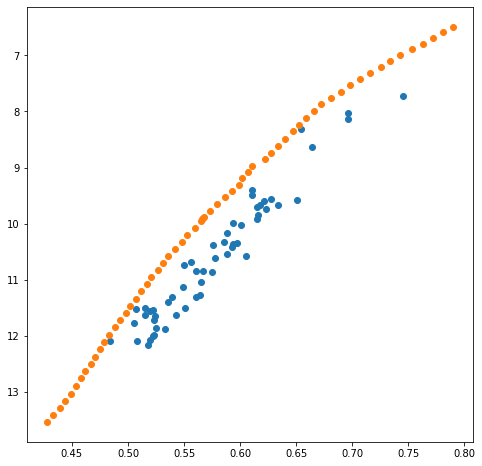

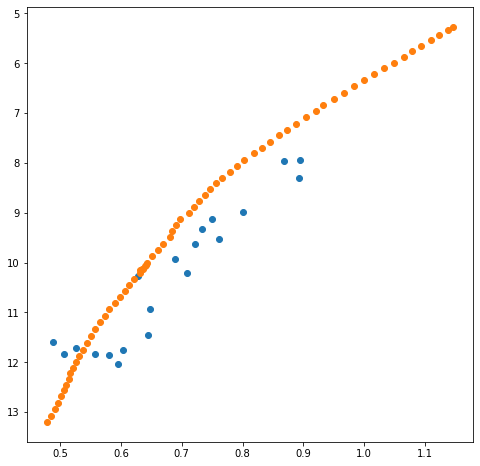

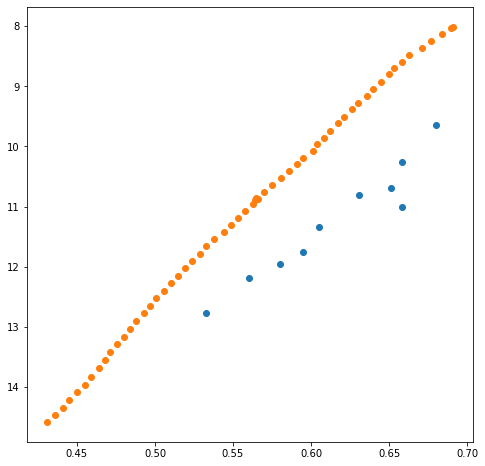

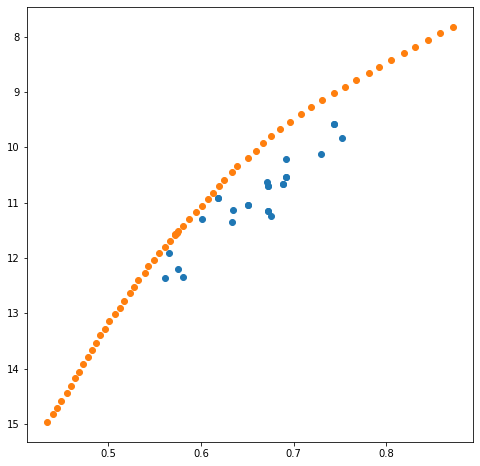

In [280]:
for i in range(len(supp2)):
    plt.figure(figsize=[8,8])
    clus = np.where(ngc_names==supp2['Cluster'][i])

    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.9032)
    
    plt.gca().invert_yaxis()
    
    plt.show()

In [284]:
10**9.5/10**9

3.1622776601683795